In [25]:
import os
import os.path as path
import re
from enum import Enum
from functools import total_ordering

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import matplotlib.patheffects as PathEffects
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm

mpl.style.use('seaborn')

# Set the default text font size
plt.rc('font', size=16)# Set the axes title font size
plt.rc('axes', titlesize=16)# Set the axes labels font size
plt.rc('axes', labelsize=16)# Set the font size for x tick labels
plt.rc('xtick', labelsize=16)# Set the font size for y tick labels
plt.rc('ytick', labelsize=16)# Set the legend font size
plt.rc('legend', fontsize=18)# Set the font size of the figure title
plt.rc('figure', titlesize=20)

In [2]:
subjPattern = re.compile(r"^\d+$")
trialPattern = re.compile(r"^(?P<block>\d\d)_(?P<trial>\d\d)(?P<data>\w+)\.tsv$")

ID01 = "00"
ID02 = "01"
ID03 = "02"
IDENTS = [ID01, ID02, ID03]

subjects = sorted([d for d in os.listdir() if subjPattern.match(d)])
print(', '.join(subjects))

001, 002, 003, 004, 005, 006, 007, 008, 009, 010, 011, 012, 013, 014, 015, 016, 017, 018, 019, 020, 021, 022, 023


In [3]:
def load_subject(subjId):
    datadict = {
        ID01 : {ID01 : [], ID02 : [], ID03 : []}, # block 1
        ID02 : {ID01 : [], ID02 : [], ID03 : []}, # block 2
        ID03 : {ID01 : [], ID02 : [], ID03 : []} # block 3
    }
    files = os.listdir(subjId)
    for file in files:
        match = trialPattern.match(file)
        if not match:
            print("Error!", path.join(subjId, file))
            continue
        block_id = match.groups()[0]
        trial_id = match.groups()[1]
        datadict[block_id][trial_id].append(file)
        
    return datadict

def load_csv(path:str) -> pd.DataFrame:
    df = pd.read_csv(path, sep='\t', usecols=lambda c: not c.startswith('Unnamed:'))
    return df

def vec2coord(s:pd.Series, keep=[0,1,2]):
    """Convert the stored vector in str: '(x,y,z)' to df with columns x&y"""
    vecs = s.apply(lambda v: np.array(v[1:-1].split(', ')).astype(float))
    p = pd.DataFrame(np.stack(vecs.values))
    p = p[p.columns[keep]]
    labels = np.array(['x', 'y', 'z'])
    p.columns = labels[:len(keep)]
    p.index = s.index
    return p

def pos2path(s:pd.Series, hallwayId:int):
    # convert text vector to 2d vector array
    # [2,0] "rotates" vector, hallways are drawn left -> right
    # so x (left, right) becomes y, and z (forward) becomes x
    p = vec2coord(s, [2,0])
    # 0-center path by subtracting hallway offset (id * 4)
    # in Unity right is positive, left is negative
    # we must negate to get correct orientation
    # then add half-width to put correct starting position
    p.y = -1 * (p.y - hallwayId * 4) + hwWidth / 2
    # add segment-length to account for first empty room behind start
    p.x += segmentLength
    return p

def round_to_multiple(number, multiple):
    return multiple * round(number / multiple)

In [4]:
@total_ordering
class Boxes(Enum):
    NoBox  = 0
    SmallL = 10
    SmallC = 11
    SmallR = 12
    LargLC = 20
    LargCR = 21
    LargLR = 22

    def __lt__(self, other):
        if self.__class__ is other.__class__:
            return self.value < other.value
        return NotImplemented

    def __int__(self):
        return self.value

# w x d x h
smBox = [.6, .3, .9]
lgBox = [.95, .3, 1.8]
pRadius = .225
hwWidth = 2.85
segmentLength = 2
hwStartX = [0, 4, 8]

hallway1 = [
            Boxes.SmallC,
            Boxes.SmallC,
            Boxes.LargCR,
            Boxes.SmallL,
            Boxes.SmallR,
            Boxes.SmallC,
            Boxes.LargLR,
            Boxes.SmallL,
            Boxes.SmallL,
            Boxes.LargLC, # transition to 5
            Boxes.SmallC,
            Boxes.SmallR,
            Boxes.LargLR,
            Boxes.SmallC,
            Boxes.SmallL,
            Boxes.SmallR,
            Boxes.LargCR,
            Boxes.SmallC,
            Boxes.SmallC
]

hallway2 = [
            Boxes.SmallL,
            Boxes.SmallC,
            Boxes.LargCR,
            Boxes.SmallL,
            Boxes.SmallL,
            Boxes.SmallR,
            Boxes.LargLC,
            Boxes.SmallR,
            Boxes.SmallL,
            Boxes.LargCR, # transition to 3
            Boxes.SmallR,
            Boxes.SmallL,
            Boxes.LargLR,
            Boxes.SmallC,
            Boxes.SmallL,
            Boxes.SmallC,
            Boxes.LargCR,
            Boxes.SmallC,
            Boxes.SmallL
]

hallway3 = [
            Boxes.SmallL,
            Boxes.SmallC,
            Boxes.LargCR,
            Boxes.SmallR,
            Boxes.SmallL,
            Boxes.SmallC,
            Boxes.LargLR,
            Boxes.SmallL,
            Boxes.SmallC,
            Boxes.LargLC, # transition to 7
            Boxes.SmallR,
            Boxes.SmallR,
            Boxes.LargLC,
            Boxes.SmallC,
            Boxes.SmallR,
            Boxes.SmallL,
            Boxes.LargCR,
            Boxes.SmallC,
            Boxes.SmallL
]

hallways = [hallway1, hallway2, hallway3]


In [5]:
def map_hallways():
    length = (4 + len(hallway1)) * segmentLength
    fig, axs = plt.subplots(3,1,figsize=(length, hwWidth*3.3))
    for idx,(ax, hallway) in enumerate(zip(axs, (hallway1, hallway2, hallway3))):
        create_map(hallway, ax)
        ax.text(-segmentLength, hwWidth/2, 
                f"HW-{idx}", fontsize=56, 
                va='center', ha='left')
        
    return fig, axs

def create_map(hallway, ax):
    # total length is 3 empty rooms + no. of obstacles
    length = (3 + len(hallway)) * segmentLength
    
    ax.set_axis_off()
    ax.set_xlim((0, length))
    ax.set_ylim((0, hwWidth))
    # background
    rect = Rectangle((0, 0), length, hwWidth, 
                     edgecolor='none', facecolor='xkcd:ivory', zorder=-15)
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    # the hallway obstacles
    # since first 2 rooms are empty, the actual first room starts at segmentLength*2
    # obstacles are placed at the end of a segment so the box starts at
    # segmentLength - boxDepth in relation to the room start
    boxPatches = []
    roomEnd = 3 * segmentLength
    for box in hallway:
        if box == Boxes.SmallL:
            dY,dX,_ = smBox
            anchor = (roomEnd - dX, hwWidth-dY)
        elif box == Boxes.SmallC:
            dY,dX,_ = smBox
            anchor = (roomEnd - dX, (hwWidth-dY) / 2)
        elif box == Boxes.SmallR:
            dY,dX,_ = smBox
            anchor = (roomEnd - dX, 0)
        elif box == Boxes.LargLC:
            dY,dX,_ = lgBox
            dY *= 2 # *2 because it's 2 boxes next to each other
            anchor = (roomEnd - dX, hwWidth-dY) 
        elif box == Boxes.LargCR:
            dY,dX,_ = lgBox
            dY *= 2 # *2 because it's 2 boxes next to each other
            anchor = (roomEnd - dX, 0)
        elif box == Boxes.LargLR:
            dY,dX,_ = lgBox
            anchor = (roomEnd - dX, hwWidth - dY)
            boxPatches.append(box_patch(anchor, dX, dY))
            anchor = (roomEnd - dX, 0)
            boxPatches.append(box_patch(anchor, dX, dY))
            
            roomEnd += segmentLength
            continue
        
        boxPatches.append(box_patch(anchor, dX, dY))
        roomEnd += segmentLength
    
    pc = PatchCollection(boxPatches, edgecolor='none',
                 facecolor='xkcd:chocolate', zorder=-10)
    ax.add_collection(pc)
    
    roomEnd = segmentLength
    dividers = []
    while roomEnd < length:
        dividers.append(Rectangle((roomEnd, 0), .1*segmentLength, hwWidth))
        roomEnd += segmentLength
    
    pc = PatchCollection(dividers, edgecolor='none', 
                         facecolor= 'xkcd:grey', alpha=.6, zorder=-5)
    ax.add_collection(pc)
                        
def box_patch(anchor, dX, dY):
    return Rectangle(anchor, dX, dY)

def draw_path(s:pd.Series, axs:plt.Axes, hwId:int, color):
    # startoffset is rounded down start position
    # offset is 0, 4 or 8
    # center start in hallway
    if not ('x' in s.columns and 'y' in s.columns):
        p = pos2path(s, hwId)
    else:
        p = s
    return axs[hwId].scatter(p.x, p.y, 24, alpha=.33, c=color), axs[hwId].plot(p.x, p.y, '--', alpha=.4, color='grey')

def draw_all_paths(subjId:str, colors = ['xkcd:maroon', 'xkcd:lightblue', 'xkcd:green']):
    datadict = load_subject(subjId)
    fig, axs = map_hallways()
    fig.suptitle(subjId, fontsize=32)

    for idx, blockId in enumerate(IDENTS):
        for trialId in IDENTS:
            trial = datadict[blockId][trialId]

            # -1 --> trial config
            filepath = path.join(subjId, trial[-1])
            df = pd.read_csv(filepath, sep='\t')
            hwId = int(df.Hallway[0][-1]) - 1

            # 0 --> engine data
            filepath = path.join(subjId, trial[0])
            df = pd.read_csv(filepath, sep='\t')
            s = df.XRHeadPos

            draw_path(s, axs, hwId, colors[idx])

In [6]:
def project_vector(v, u):
    """Project vector v onto vector u"""
    return np.dot(v, u) / np.dot(u, u) * u

def point_in_rectangle(P:np.ndarray, A:np.ndarray, B:np.ndarray, C:np.ndarray, D:np.ndarray):
    """All points must be a 2x1 or 1x2 array. A -> D must be counter-clockwise corners of rectangle"""
    return 0 <= np.dot(P-A, B-A) <= np.dot(B-A, B-A) and 0 <= np.dot(P-A, D-A) <= np.dot(D-A, D-A)

def triangle_area(A,B,C):
    return np.abs(A[0]*(B[1]-C[1]) + B[0]*(C[1]-A[1]) + C[0]*(A[1]-B[1])) / 2

def point_in_quadrilateral(P, A, B, C, D):
    """Assumes convex quardilateral"""
    quad_area = triangle_area(A,B,D) + triangle_area(B,C,D)
    point_area = triangle_area(P,A,B) \
                + triangle_area(P,B,C) \
                + triangle_area(P,C,D) \
                + triangle_area(P,D,A)
    
    # accounting for floating point errors, 
    # if they are close enough, consider equal and poing inside
    return np.abs(point_area - quad_area) < 1e-7


def segment_to_point_distance_squared(P:np.ndarray, A:np.ndarray, B:np.ndarray):
    AP = P - A # vector from segment start to point
    AB = B - A # line segment
    D = A + project_vector(AP, AB) # project vector-to-point onto segment
    AD = D - A # vector from projected endpoint to segment start for 
    
    non_zero = np.where(AB != 0)[0]
    # check if projected point is on line segment
    if len(non_zero) > 0: # calculate scale of segment to projection
        k = (AD[non_zero] / AB[non_zero])[np.argmax(np.abs(AD[non_zero] / AB[non_zero]))]
    else:
        k = 0
    
    if k <= 0: # negative scale: is "behind" segment start
        return np.dot(AP , AP)
    elif k >= 1: # positive scale: is "beyond" segment
        return np.dot(P-B, P-B)
    else: # is on segment
        return np.dot(P-D, P-D)

def segment_intersects_circle(C:np.ndarray, r:float, A:np.ndarray, B:np.ndarray):
    dist = segment_to_point_distance_squared(C, A, B)
    # print(f"smallest distance from: {np.array2string(C, precision=3)} to" +
    #     f"Segment [{np.array2string(A)} -> {np.array2string(B)}]: {dist:.3f} :: R^2: {r*r:.3f}")
    return dist <= r*r

def circle_overlaps_rectangle(circle_center:np.ndarray, r:float, A:np.ndarray, B:np.ndarray, C:np.ndarray, D:np.ndarray):
    return  point_in_rectangle(circle_center, A, B, C, D) or \
            segment_intersects_circle(circle_center, r, A, B) or \
            segment_intersects_circle(circle_center, r, B, C) or \
            segment_intersects_circle(circle_center, r, C, D) or \
            segment_intersects_circle(circle_center, r, D, A)

def get_box_bb(box:Boxes, segmentEnd:float):
    if box == Boxes.SmallL:
        dY,dX,_ = smBox
        ll = [segmentEnd-dX, hwWidth-dY], None
    elif box == Boxes.SmallC:
        dY,dX,_ = smBox
        ll = [segmentEnd-dX, (hwWidth-dY) / 2], None
    elif box == Boxes.SmallR:
        dY,dX,_ = smBox
        ll = [segmentEnd-dX, 0], None
    elif box == Boxes.LargLC:
        dY,dX,_ = lgBox
        dY *= 2 # *2 because it's 2 boxes next to each other
        ll = [segmentEnd-dX, hwWidth-dY], None
    elif box == Boxes.LargCR:
        dY,dX,_ = lgBox
        dY *= 2 # *2 because it's 2 boxes next to each other
        ll = [segmentEnd-dX, 0], None
    elif box == Boxes.LargLR:
        dY,dX,_ = lgBox
        ll = [segmentEnd-dX, hwWidth - dY], [segmentEnd-dX, 0]
    else:
        return None, None

    ll = np.array(ll[0]), np.array(ll[1])
    lr = ll[0] + [dX, 0], (ll[1] + [dX, 0] if ll[1].shape != () else ll[1])
    ul = ll[0] + [0, dY], (ll[1] + [0, dY] if ll[1].shape != () else ll[1])
    ur = ul[0] + [dX, 0], (ul[1] + [dX, 0] if ul[1].shape != () else ll[1])

    return (ll[0], lr[0], ur[0], ul[0]), (ll[1], lr[1], ur[1], ul[1])

def collision_at_point(s:pd.Series) -> bool:
    x = s.x
    y = s.y
    zone = s.closestBoxZone
    box = s.closeBox
    rec1, rec2 = get_box_bb(box, (zone+1) * segmentLength)
    if rec1 is None:
        return False
    P = np.array([x, y])
    coll = circle_overlaps_rectangle(P, pRadius, rec1[0], rec1[1], rec1[2], rec1[3])
    if rec2[0].shape == ():
        return coll
    coll = coll or circle_overlaps_rectangle(P, pRadius, rec2[0], rec2[1], rec2[2], rec2[3])
    return coll
    

def distance_to_box_at_point(s:pd.Series) -> float:
    x = s.x
    y = s.y
    zone = s.closestBoxZone
    box = s.closeBox
    rec1, rec2 = get_box_bb(box, (zone+1) * segmentLength)
    if rec1 is None:
        return float('inf')
    P = np.array([x, y])
    dist = player_dist_to_box(P, rec1[0], rec1[1], rec1[2], rec1[3])
    if rec2[0].shape == ():
        return dist
    dist = min(dist, player_dist_to_box(P, rec2[0], rec2[1], rec2[2], rec2[3]))
    return dist


def player_dist_to_box(pos, A, B, C, D):
    if point_in_rectangle(pos, A, B, C, D):
        return 0
    return max(min(np.sqrt(segment_to_point_distance_squared(pos, A, B)),
                np.sqrt(segment_to_point_distance_squared(pos, B, C)),
                np.sqrt(segment_to_point_distance_squared(pos, C, D)),
                np.sqrt(segment_to_point_distance_squared(pos, D, A))) - pRadius, 0)

@total_ordering
class Collisions(Enum):
    no = 0
    bump = 1
    strafe = 2
    crash = 5

    def __lt__(self, other):
        if self.__class__ is other.__class__:
            return self.value < other.value
        return NotImplemented


delta = segmentLength / 2 * np.array([np.cos(np.deg2rad(60)), np.sin(np.deg2rad(60))])

def classify_collision(pos, r, A, B, C, D):
    # inside the box is a crash
    if point_in_rectangle(pos, A, B, C, D):
        return Collisions.crash
    ##### Outside of Box
    # on side of box
    if A[0] < pos[0] < D[0]:
        return Collisions.strafe
    # past the box position
    if D[0] <= pos[0]:
        # check in bumpzone
        if point_in_quadrilateral(pos, D, C, C+delta, D+(delta*np.array([1,-1]))):
            return Collisions.bump
        # else is a strafe
        else:
            return Collisions.strafe
    # still in front of box
    if A[0] >= pos[0]:
        # check if in crash / front zone
        if point_in_quadrilateral(pos, A+(delta*-1),A,B,B+(delta*np.array([-1,1]))):
            return Collisions.crash
        # sideways enough to be strafe
        else:
            return Collisions.strafe
    
    return Collisions.no
    
def collision_type_at_point(s:pd.Series) -> float:
    x = s.x
    y = s.y
    zone = s.closestBoxZone
    box = s.closeBox
    rec1, rec2 = get_box_bb(box, (zone+1) * segmentLength)
    if rec1 is None:
        return Collisions.no

    P = np.array([x, y])
    # more than radius away from box
    if distance_to_box_at_point(s) > 0:
        return Collisions.no

    coll = classify_collision(P, pRadius, rec1[0], rec1[1], rec1[2], rec1[3])
    # if moving forward bump becomes strafe
    if s.direction and coll is Collisions.bump:
        coll = Collisions.strafe

    if rec2[0].shape == ():
        return coll
    coll2 = classify_collision(P, pRadius, rec2[0], rec2[1], rec2[2], rec2[3])
    return max(coll, coll2)

def count_zones_with_collision(subjId):
    counts = np.zeros((3,3,2))
    dfs = np.zeros((3,3), dtype=object)
    hwIds = np.zeros((3,3), dtype=int)
    blocks = load_subject(subjId)
    for blockIdx, (block, trials) in enumerate(blocks.items()):
        for trialIdx, (trial, files) in enumerate(trials.items()):
            try:
                dfEng = load_csv(path.join(subjId, files[0]))
                dfCfg = load_csv(path.join(subjId, files[-1]))
                hwId = int(dfCfg.values[0,1][-1]) - 1
                condition = dfCfg.GazeCondition.iloc[0].lower()
                conIdx = 0 if 'ignored' in condition else 1 if 'fixed' in condition else 2
                hallway = hallway1 if hwId == 0 else (hallway2 if hwId == 1 else hallway3)
                seconds = (dfEng.TimeStamp - dfEng.TimeStamp.iloc[0]) / 1e7
                time_taken = seconds.iloc[-1]
                
                dfEng.set_index('TimeStamp', inplace=True)
                head_pos = pos2path(dfEng.XRHeadPos, hwId)
                
                head_pos['closestBoxZone'] = ((head_pos.x - segmentLength / 2) // 2).astype(int)
                layout = [Boxes.NoBox, Boxes.NoBox] + hallway + [Boxes.NoBox]
                head_pos['closeBox'] = head_pos.closestBoxZone.apply(lambda i: layout[i])
                
                dist = head_pos.apply(lambda r: distance_to_box_at_point(r), axis=1)
                dist.replace(np.inf, dist[dist != np.inf].max(), inplace=True)
                head_pos['distanceToBox'] = dist
                head_pos['collision'] = dist == 0
                
                collC = head_pos.groupby('closestBoxZone')['collision'].max().sum()
                counts[blockIdx, conIdx] = [collC, time_taken]
                hwIds[blockIdx, conIdx] = hwId
                dfs[blockIdx, conIdx] = head_pos
            except Exception as e:
                print(f"Error in subject {subjId}, Block {block} Trial {trial}")
                raise e
            
    return counts, hwIds, dfs

def classify_all_collisions(subjId):
    blockDfs = []
    blocks = load_subject(subjId)
    for blockIdx, (block, trials) in enumerate(blocks.items()):
        dfs = []
        trial_cfg = []
        for trialIdx, (trial, files) in enumerate(trials.items()):
            files = sorted(files)
            try:
                dfEng = load_csv(path.join(subjId, files[0]))
                dfCfg = load_csv(path.join(subjId, files[-1]))
                
                hwId = int(dfCfg.values[0,1][-1]) - 1
                condition = dfCfg.GazeCondition.iloc[0].lower()
                conIdx = 0 if 'ignored' in condition else 1 if 'fixed' in condition else 2
                conTxt = 'G.Ignored' if conIdx == 0 else 'G.Locked' if conIdx == 1 else 'G.Assisted'
                hallway = hallway1 if hwId == 0 else (hallway2 if hwId == 1 else hallway3)
                dfEng = dfEng.loc[dfEng.TimeStamp.diff() > 0]
                seconds = (dfEng.TimeStamp - dfEng.TimeStamp.iloc[0]) / 1e7
                seconds.index = dfEng.TimeStamp
                
                dfEng.set_index('TimeStamp', inplace=True)
                head_pos = pos2path(dfEng.XRHeadPos, hwId)
                
                head_pos['closestBoxZone'] = ((head_pos.x - segmentLength / 2) // 2).astype(int)
                layout = [Boxes.NoBox, Boxes.NoBox] + hallway + [Boxes.NoBox]
                head_pos['closeBox'] = head_pos.closestBoxZone.apply(lambda i: layout[i])

                head_pos['direction'] = head_pos['x'].diff(-5) < 0
                head_pos['collision'] = head_pos.apply(lambda r: collision_type_at_point(r), axis=1)

                head_pos['seconds'] = seconds

                trial_cfg.append((conTxt, hwId))
                dfs.append(head_pos)
            except Exception as e:
                print(f"Error in subject {subjId}, Block {block} Trial {trial}")
                raise e
            
        blockDfs.append(pd.concat(dfs, axis=0, keys=trial_cfg, names=['Condition', 'TimeStamp']))


    df = pd.concat(blockDfs, axis=0, keys=IDENTS, names=['Block', 'Condition', 'HallwayId','TimeStamp'])
    return df

((1077074, 9), (974505, 9))

In [21]:
try:
    # raise Exception("Out of date")
    dfColl = pd.read_hdf('data.h5', key='collisions')
except Exception as e:
    print("Error reading data.h5", type(e), e)
    collisions = []
    for idx, subjId in enumerate(tqdm(subjects)):
        df = classify_all_collisions(subjId)
        collisions.append(df)

    dfColl = pd.concat(collisions, axis=0, keys=subjects, names=['Subject', 'Block', 'Condition', 'HallwayId', 'TimeStamp'])

    # drop duplicate entries, reorder index and sort by block and time
    dfColl = dfColl[~dfColl.index.duplicated(keep='first')].reorder_levels([1,2,3,0,4]).sort_index(level=[0,4])
    
    dfColl.to_hdf('data.h5', key='collisions', complevel=7)

print(", ".join(dfColl.index.get_level_values(3).unique()))
print(dfColl.shape)
dfColl.head(5)

001, 002, 003, 004, 005, 006, 007, 008, 009, 010, 011, 012, 013, 014, 015, 016, 017, 018, 019, 020, 021, 022, 023
(1077074, 9)


x        y  \
Block Condition HallwayId Subject TimeStamp                              
00    G.Ignored 1         001     637933112670500486  3.82038  1.29802   
                                  637933112670650501  3.82275  1.29773   
                                  637933112670850483  3.82354  1.29756   
                                  637933112671100495  3.82625  1.29710   
                                  637933112671330511  3.82795  1.29665   

                                                      closestBoxZone  \
Block Condition HallwayId Subject TimeStamp                            
00    G.Ignored 1         001     637933112670500486               1   
                                  637933112670650501               1   
                                  637933112670850483               1   
                                  637933112671100495               1   
                                  637933112671330511               1   

                                                         closeBox  direction  \
Block Condition HallwayId Subject TimeStamp                                    
00    G.Ignored 1         001     637933112670500486  Boxes.NoBox       True   
                                  637933112670650501  Boxes.NoBox       True   
                                  637933112670850483  Boxes.NoBox       True   
                                  637933112671100495  Boxes.NoBox       True   
                                  637933112671330511  Boxes.NoBox       True   

                                                          collision   seconds  \
Block Condition HallwayId Subject TimeStamp                                     
00    G.Ignored 1         001     637933112670500486  Collisions.no  0.000000   
                                  637933112670650501  Collisions.no  0.015001   
                                  637933112670850483  Collisions.no  0.035000   
                                  637933112671100495  Collisions.no  0.060001   
                                  637933112671330511  Collisions.no  0.083003   

                                                     GroupedCollision  \
Block Condition HallwayId Subject TimeStamp                             
00    G.Ignored 1         001     637933112670500486    Collisions.no   
                                  637933112670650501    Collisions.no   
                                  637933112670850483    Collisions.no   
                                  637933112671100495    Collisions.no   
                                  637933112671330511    Collisions.no   

                                                      CollisionGroup  
Block Condition HallwayId Subject TimeStamp                           
00    G.Ignored 1         001     637933112670500486           326.0  
                                  637933112670650501           326.0  
                                  637933112670850483           326.0  
                                  637933112671100495           326.0  
                                  637933112671330511           326.0

In [22]:
def classify_by_threshold(df, threshold=.3):
    df = df[df != Collisions.no]
    rel_counts = df.value_counts() / len(df)
    try:
        if rel_counts[Collisions.crash] > threshold:
            return Collisions.crash
    except KeyError:
        pass
    if len(rel_counts) > 0:
        return rel_counts.idxmax()
    return Collisions.no

### group continuous collisions and overwrite with highest collision type
# find transitions between collisions
collGroups = dfColl.groupby(['Block', 'Condition', 'HallwayId', 'Subject'], group_keys=False).apply(lambda df: df.loc[df['collision'].shift() != df['collision']])
# count no collision as group ID
collGroups['CollisionGroup'] = (collGroups['collision'] == Collisions.no).cumsum()
# assign group to all time points
dfColl['CollisionGroup'] = np.nan
dfColl.loc[collGroups.index, "CollisionGroup"] = collGroups.CollisionGroup
dfColl['CollisionGroup'].ffill(inplace=True)
# classify entire collision group
collClass = dfColl.groupby('CollisionGroup')['collision'].apply(classify_by_threshold, threshold=.3)

# assign group label to each time point
dfColl['GroupedCollision'] = dfColl.apply(lambda r: Collisions.no if r.collision == Collisions.no else collClass.loc[r.CollisionGroup], axis=1)

dfColl.head(5)

x        y  \
Block Condition HallwayId Subject TimeStamp                              
00    G.Ignored 1         001     637933112670500486  3.82038  1.29802   
                                  637933112670650501  3.82275  1.29773   
                                  637933112670850483  3.82354  1.29756   
                                  637933112671100495  3.82625  1.29710   
                                  637933112671330511  3.82795  1.29665   

                                                      closestBoxZone  \
Block Condition HallwayId Subject TimeStamp                            
00    G.Ignored 1         001     637933112670500486               1   
                                  637933112670650501               1   
                                  637933112670850483               1   
                                  637933112671100495               1   
                                  637933112671330511               1   

                                                         closeBox  direction  \
Block Condition HallwayId Subject TimeStamp                                    
00    G.Ignored 1         001     637933112670500486  Boxes.NoBox       True   
                                  637933112670650501  Boxes.NoBox       True   
                                  637933112670850483  Boxes.NoBox       True   
                                  637933112671100495  Boxes.NoBox       True   
                                  637933112671330511  Boxes.NoBox       True   

                                                          collision   seconds  \
Block Condition HallwayId Subject TimeStamp                                     
00    G.Ignored 1         001     637933112670500486  Collisions.no  0.000000   
                                  637933112670650501  Collisions.no  0.015001   
                                  637933112670850483  Collisions.no  0.035000   
                                  637933112671100495  Collisions.no  0.060001   
                                  637933112671330511  Collisions.no  0.083003   

                                                     GroupedCollision  \
Block Condition HallwayId Subject TimeStamp                             
00    G.Ignored 1         001     637933112670500486    Collisions.no   
                                  637933112670650501    Collisions.no   
                                  637933112670850483    Collisions.no   
                                  637933112671100495    Collisions.no   
                                  637933112671330511    Collisions.no   

                                                      CollisionGroup  
Block Condition HallwayId Subject TimeStamp                           
00    G.Ignored 1         001     637933112670500486           326.0  
                                  637933112670650501           326.0  
                                  637933112670850483           326.0  
                                  637933112671100495           326.0  
                                  637933112671330511           326.0

In [175]:
dfColl.to_hdf('data.h5', key='collisions', complevel=7)

/tmp/ipykernel_482/2720402409.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['closeBox', 'collision', 'GroupedCollision'], dtype='object')]

  dfColl.to_hdf('data.h5', key='collisions', complevel=7)


/tmp/ipykernel_429/2082190416.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(3,1,figsize=(length, hwWidth*3.3))


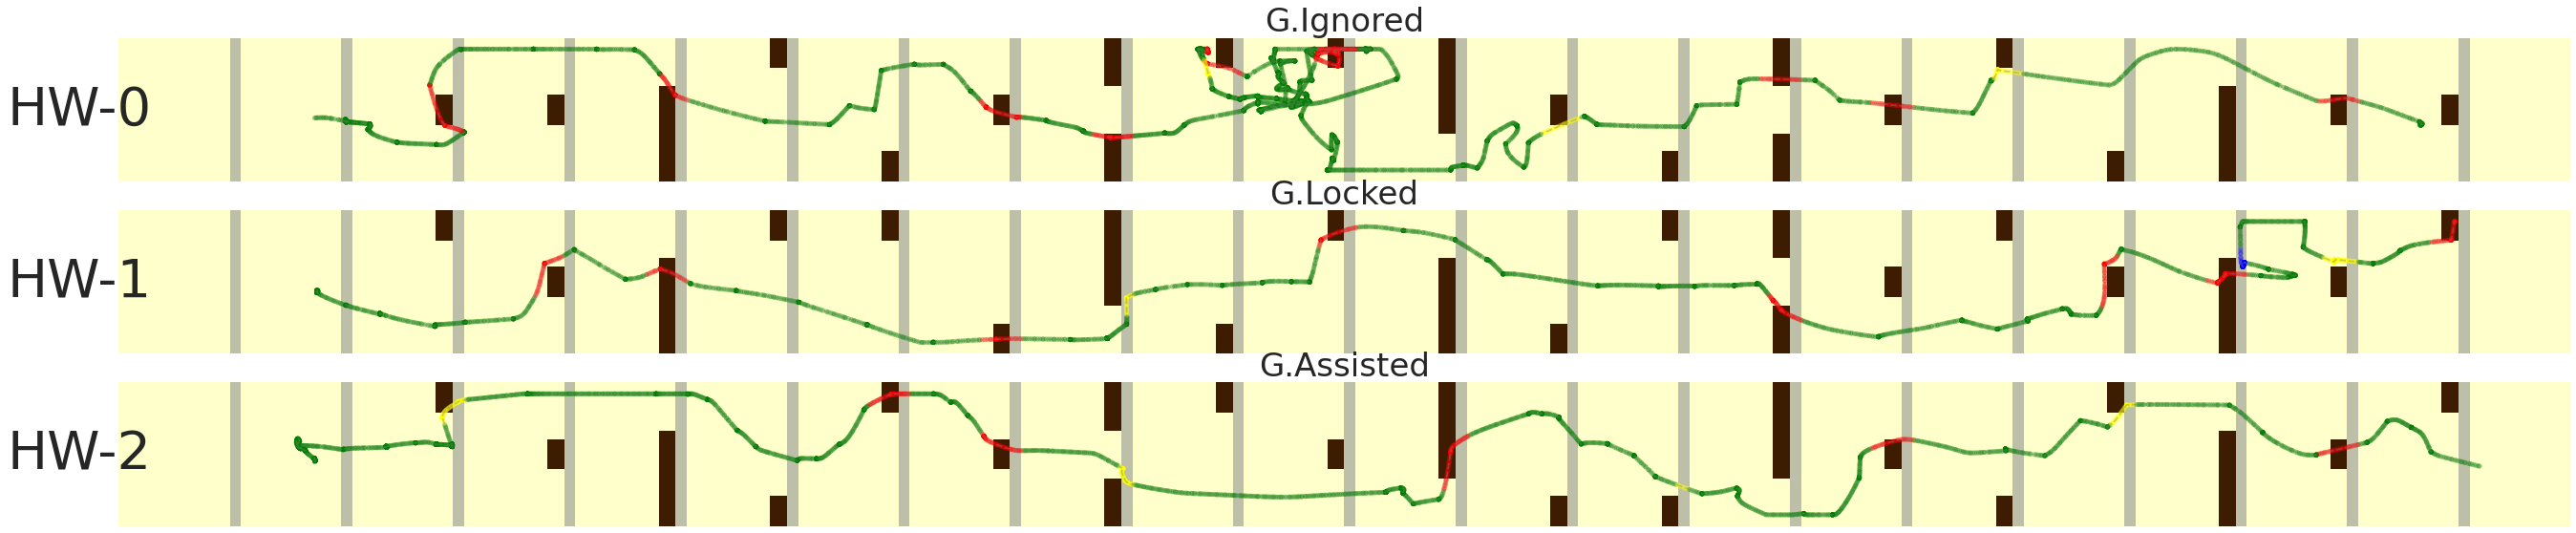

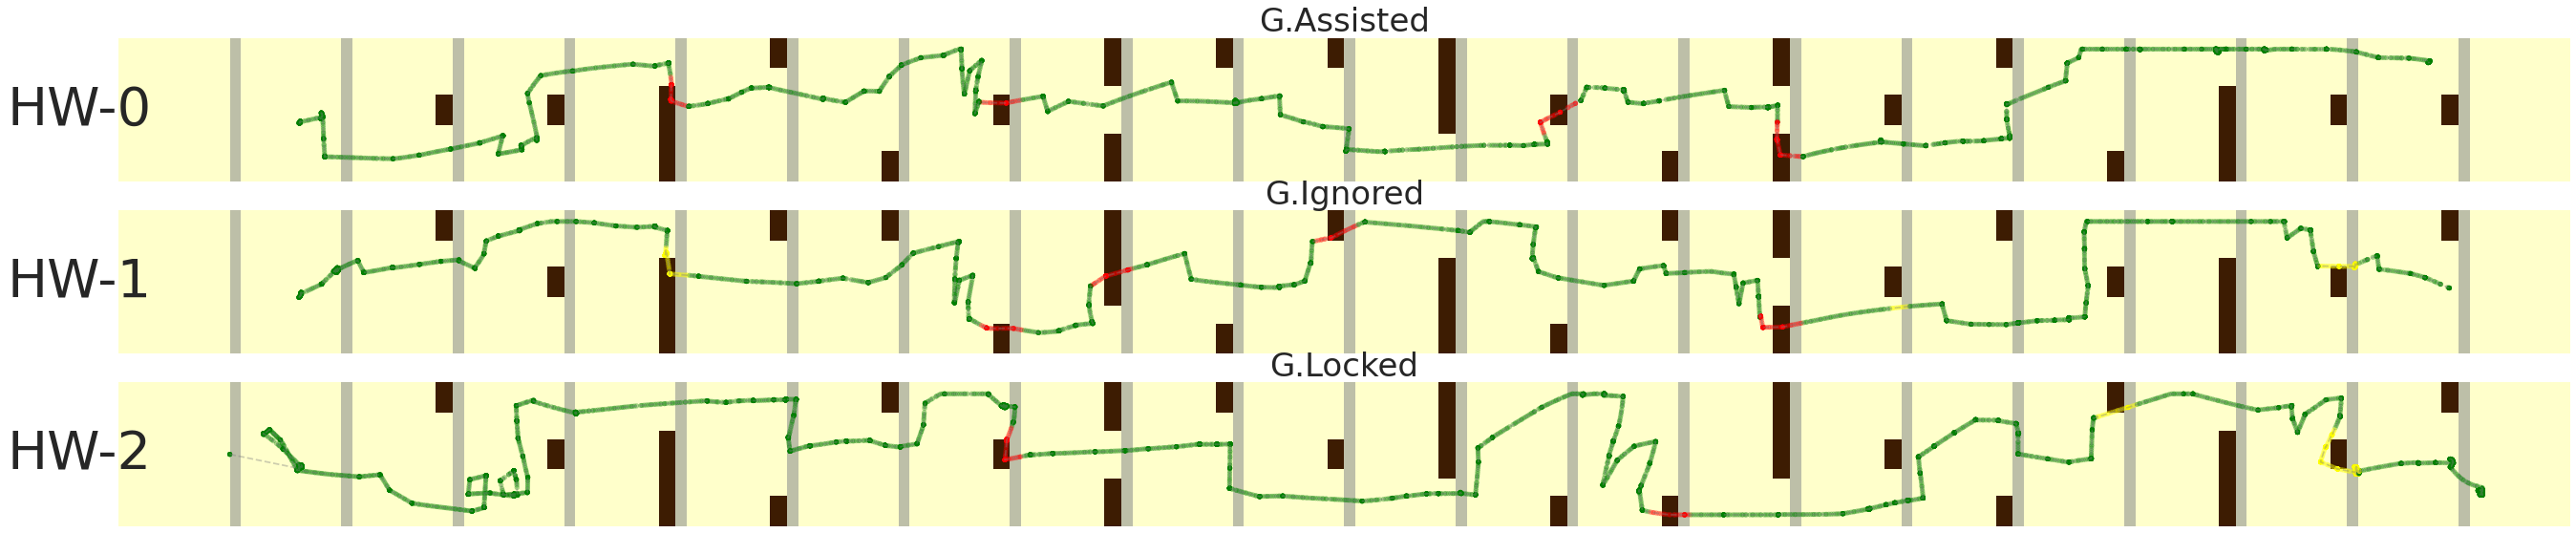

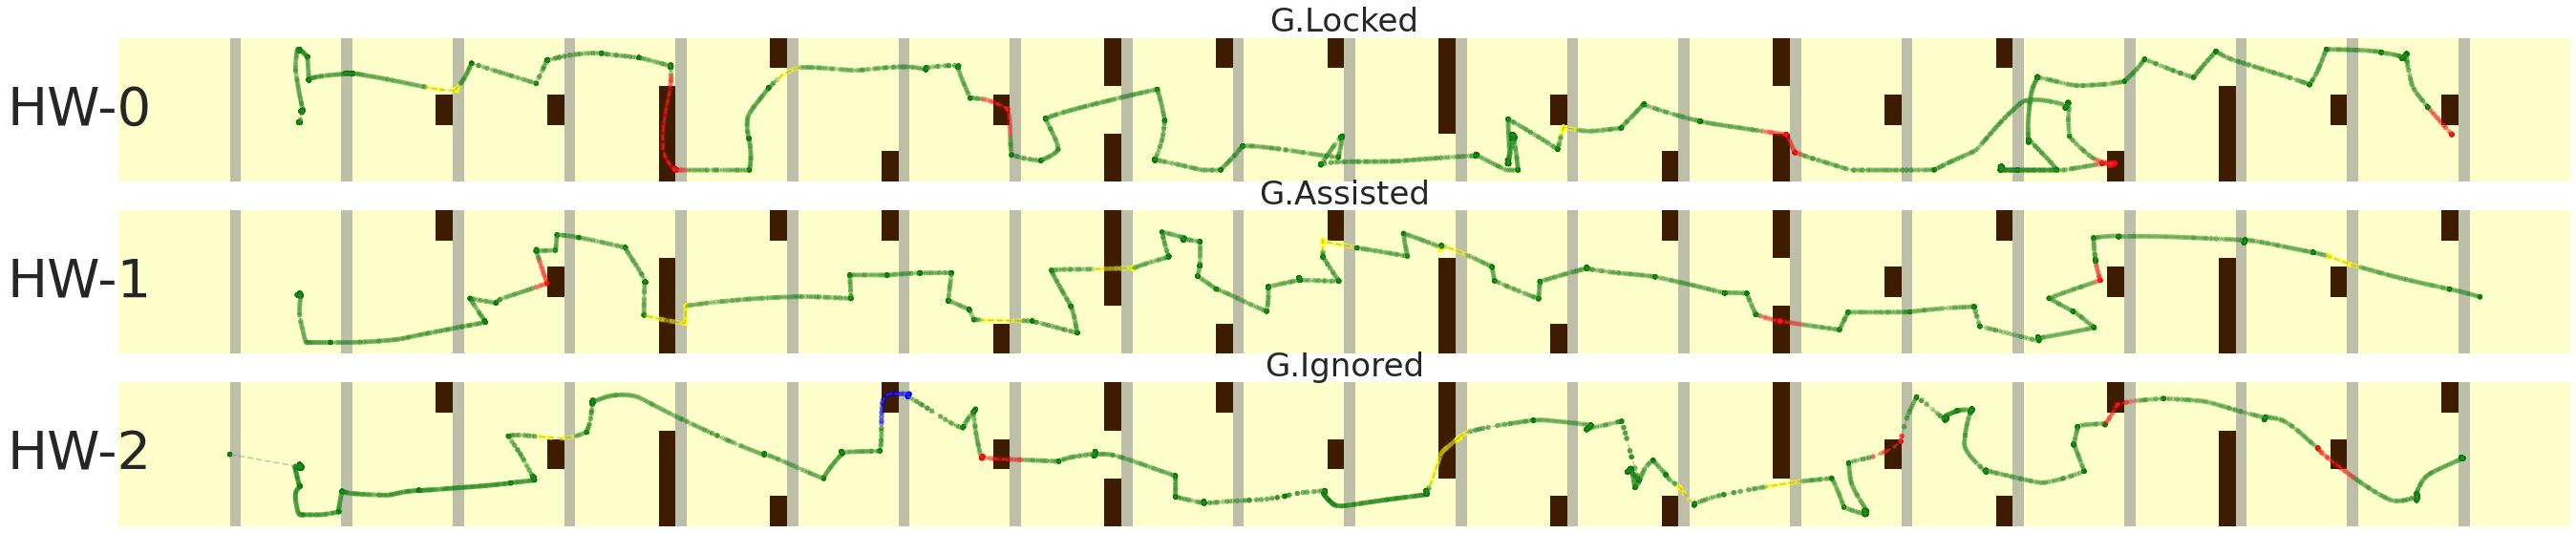

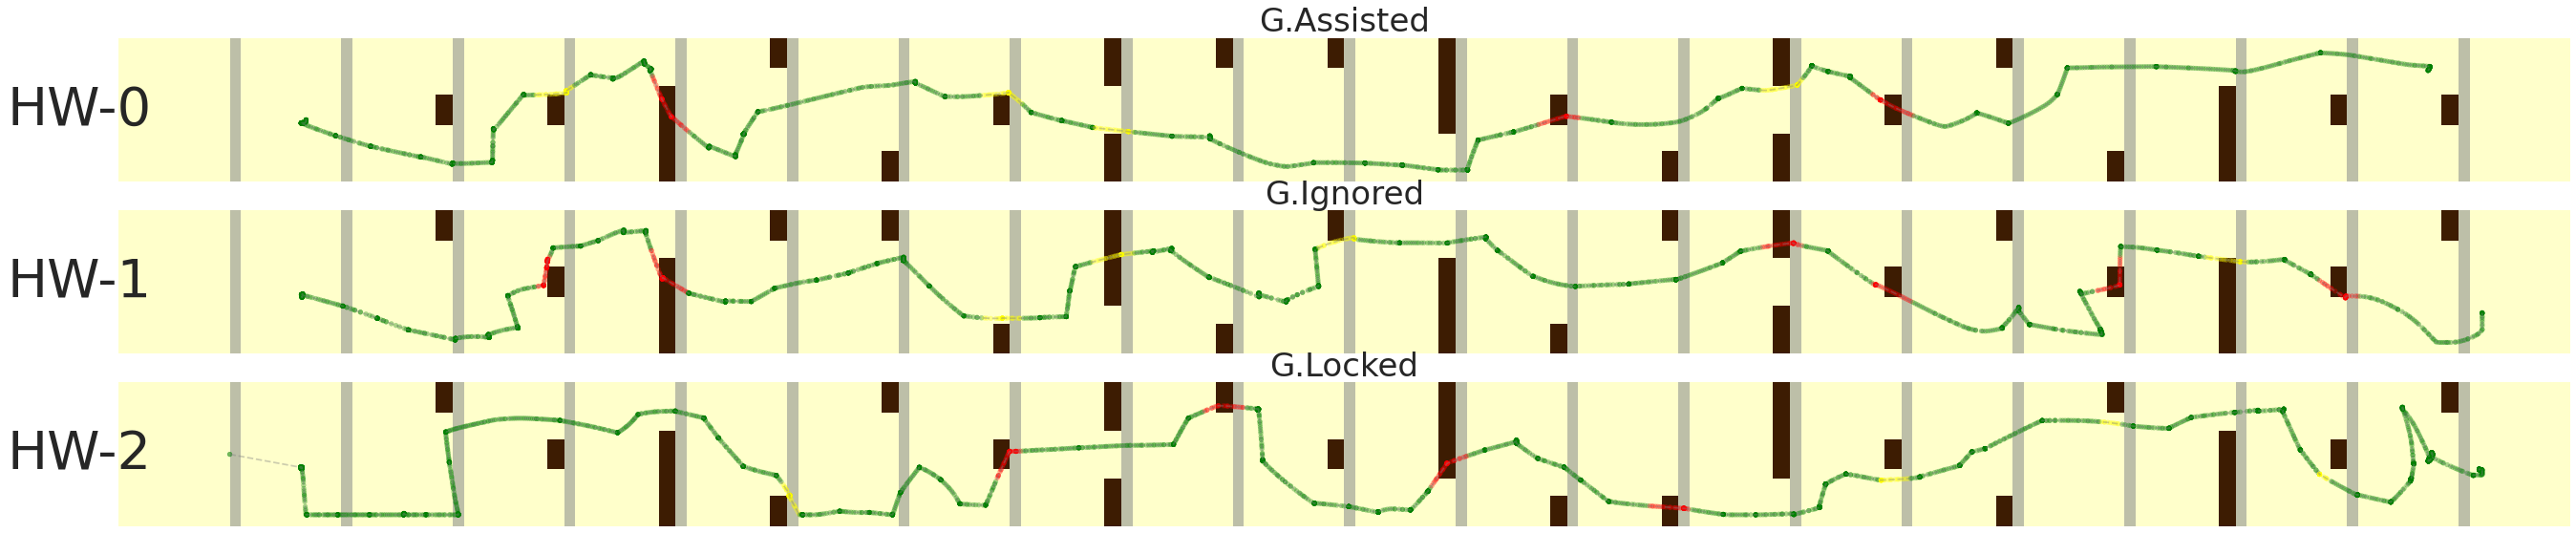

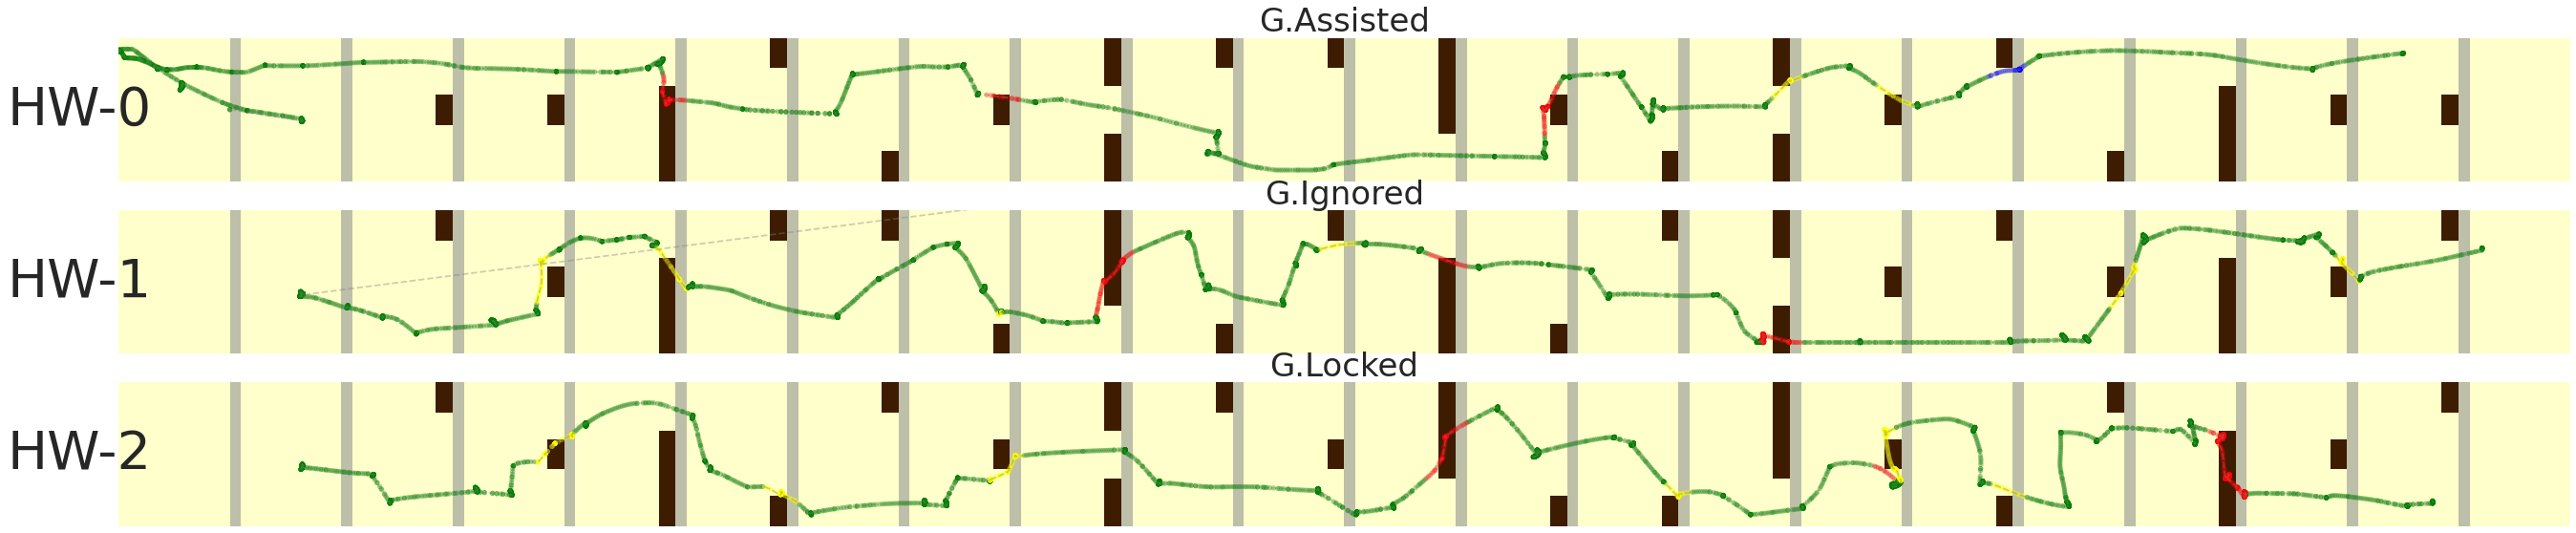

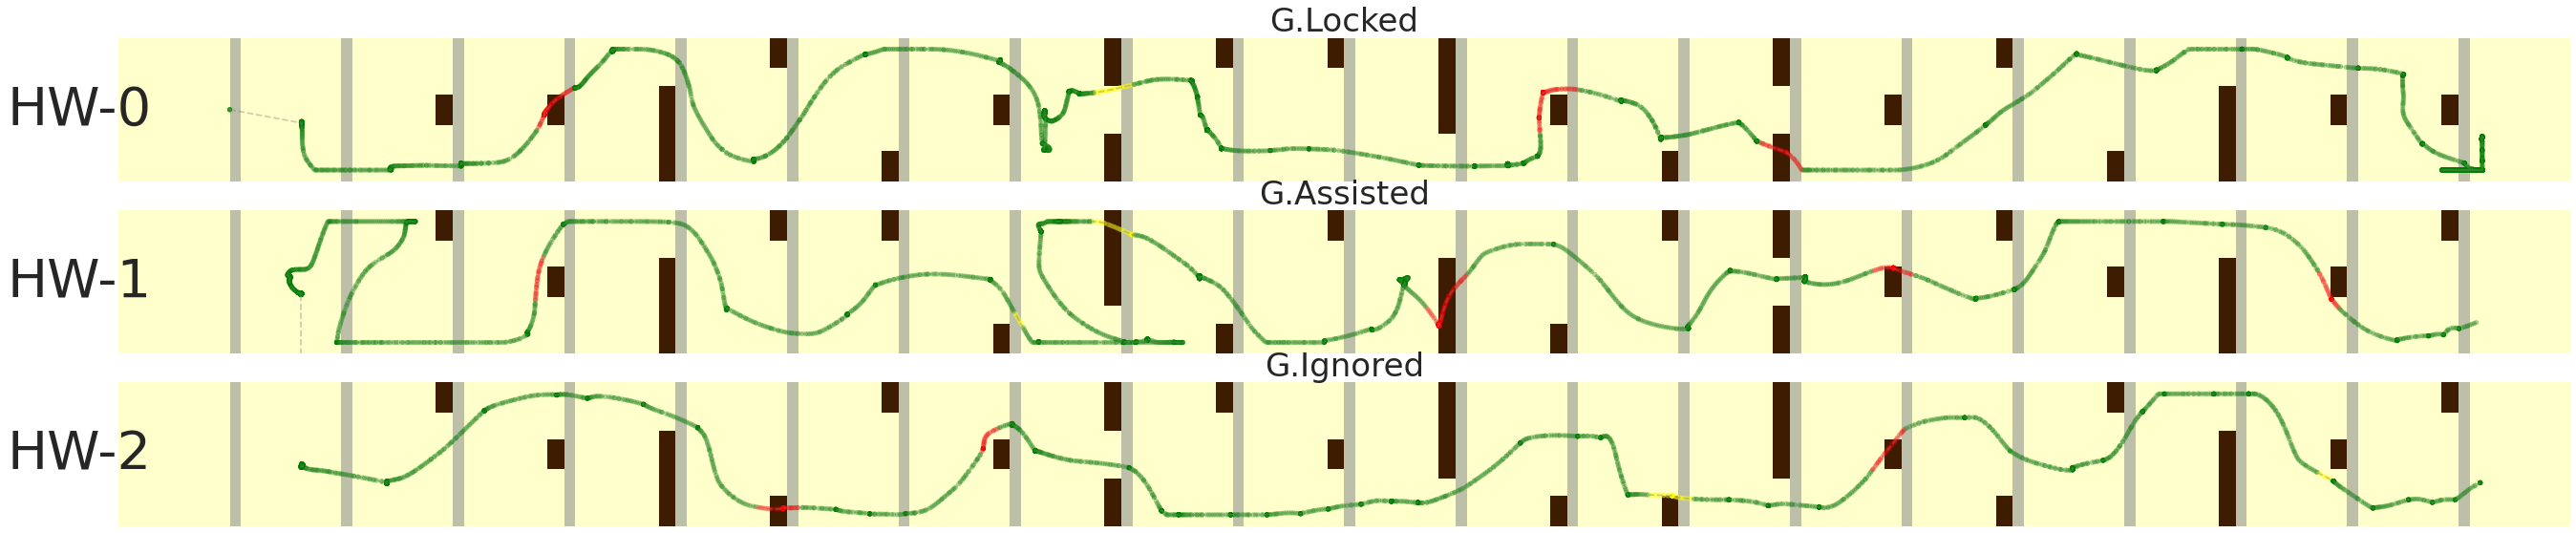

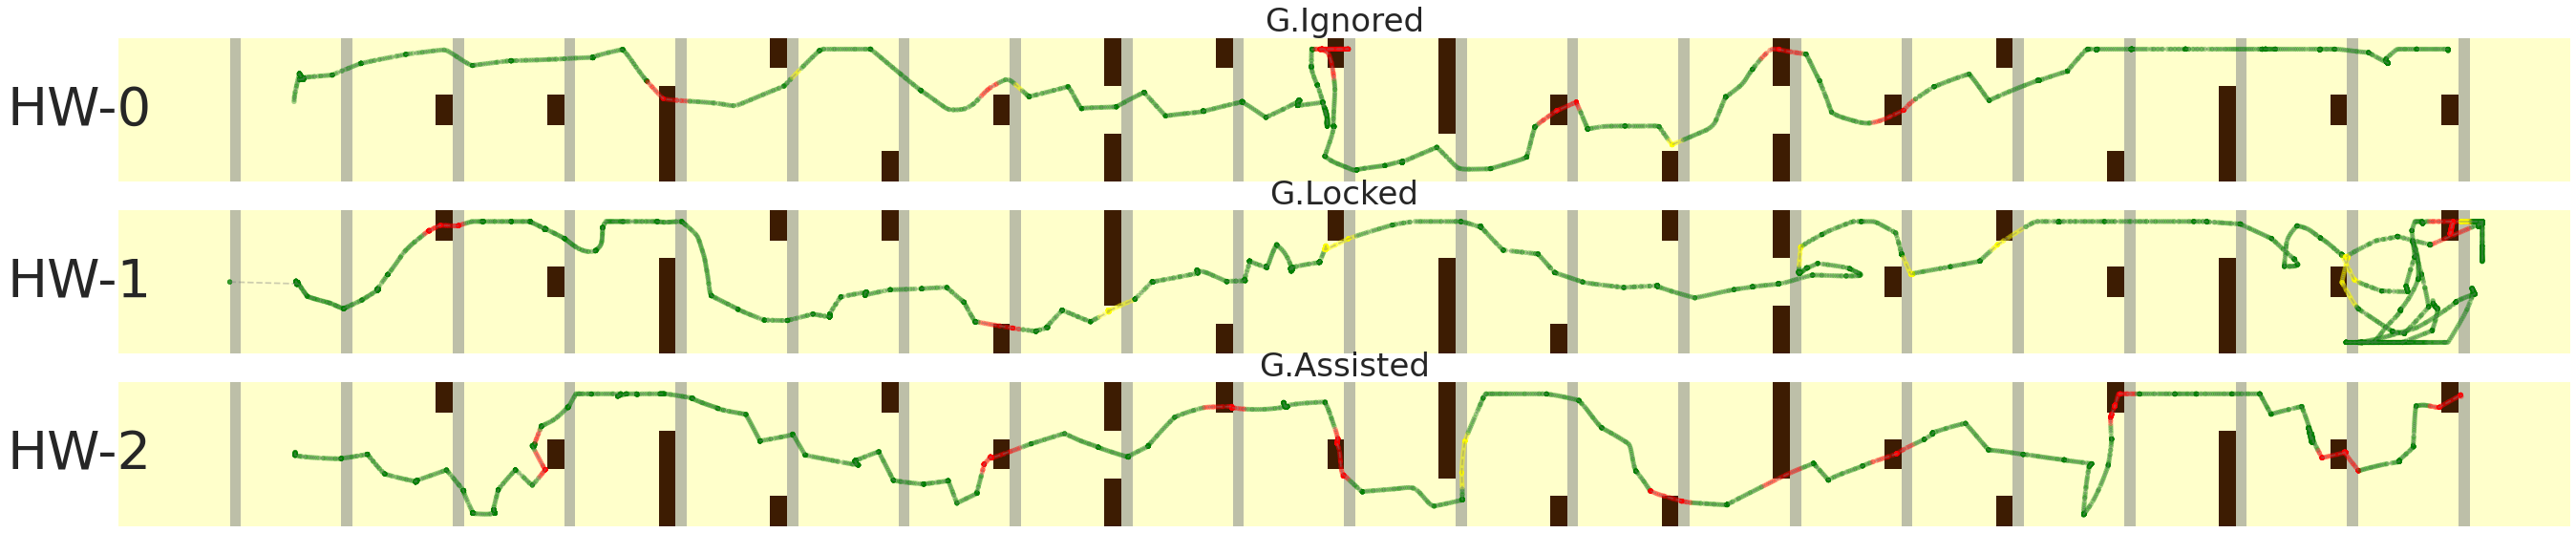

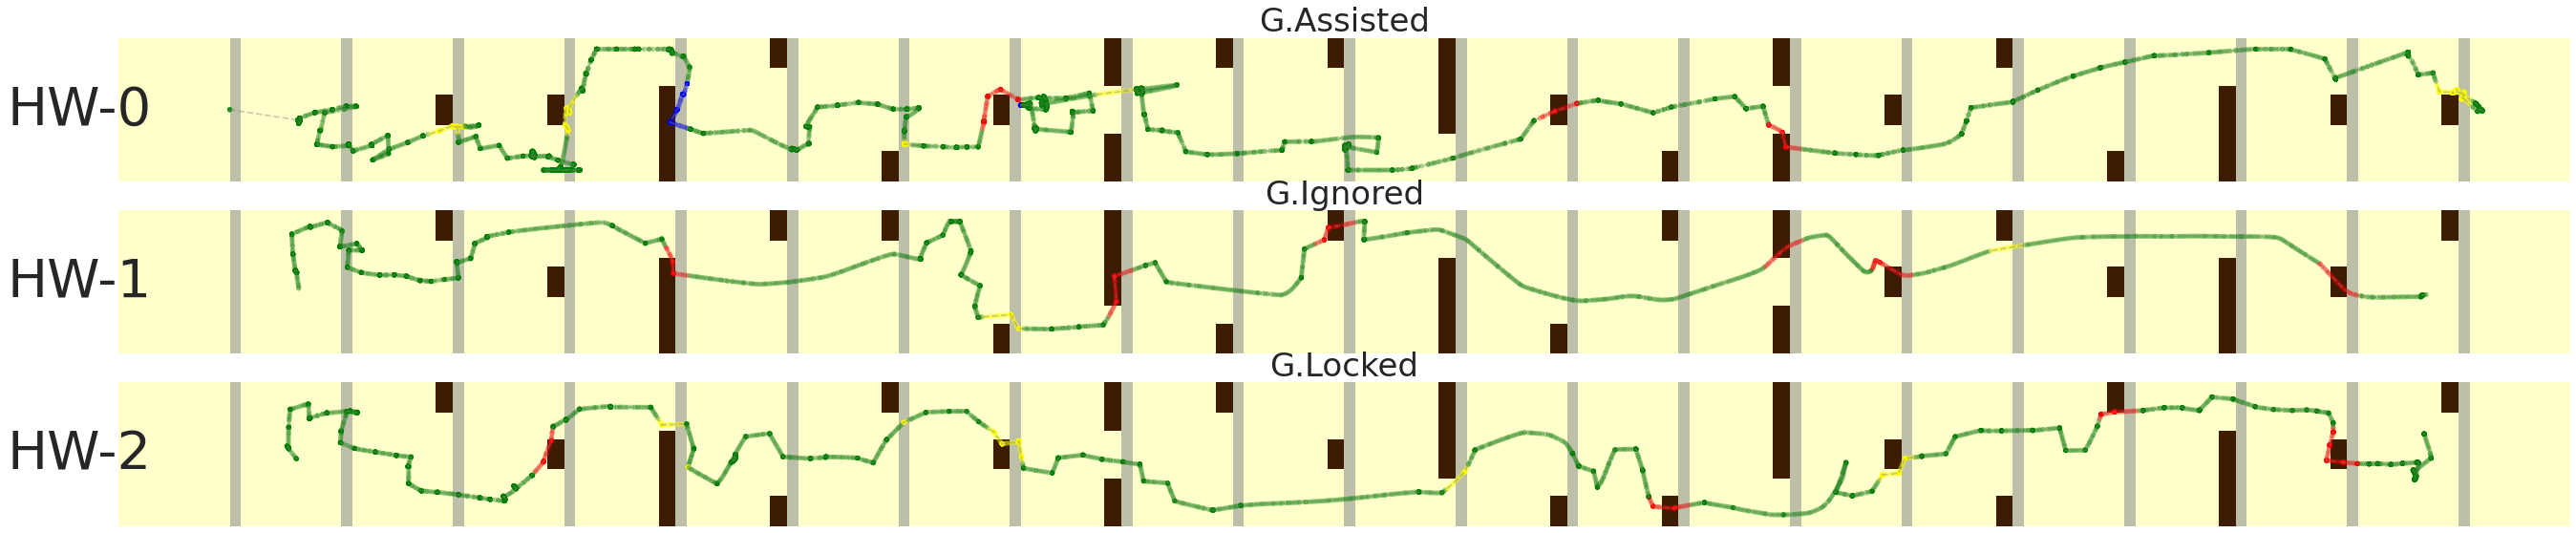

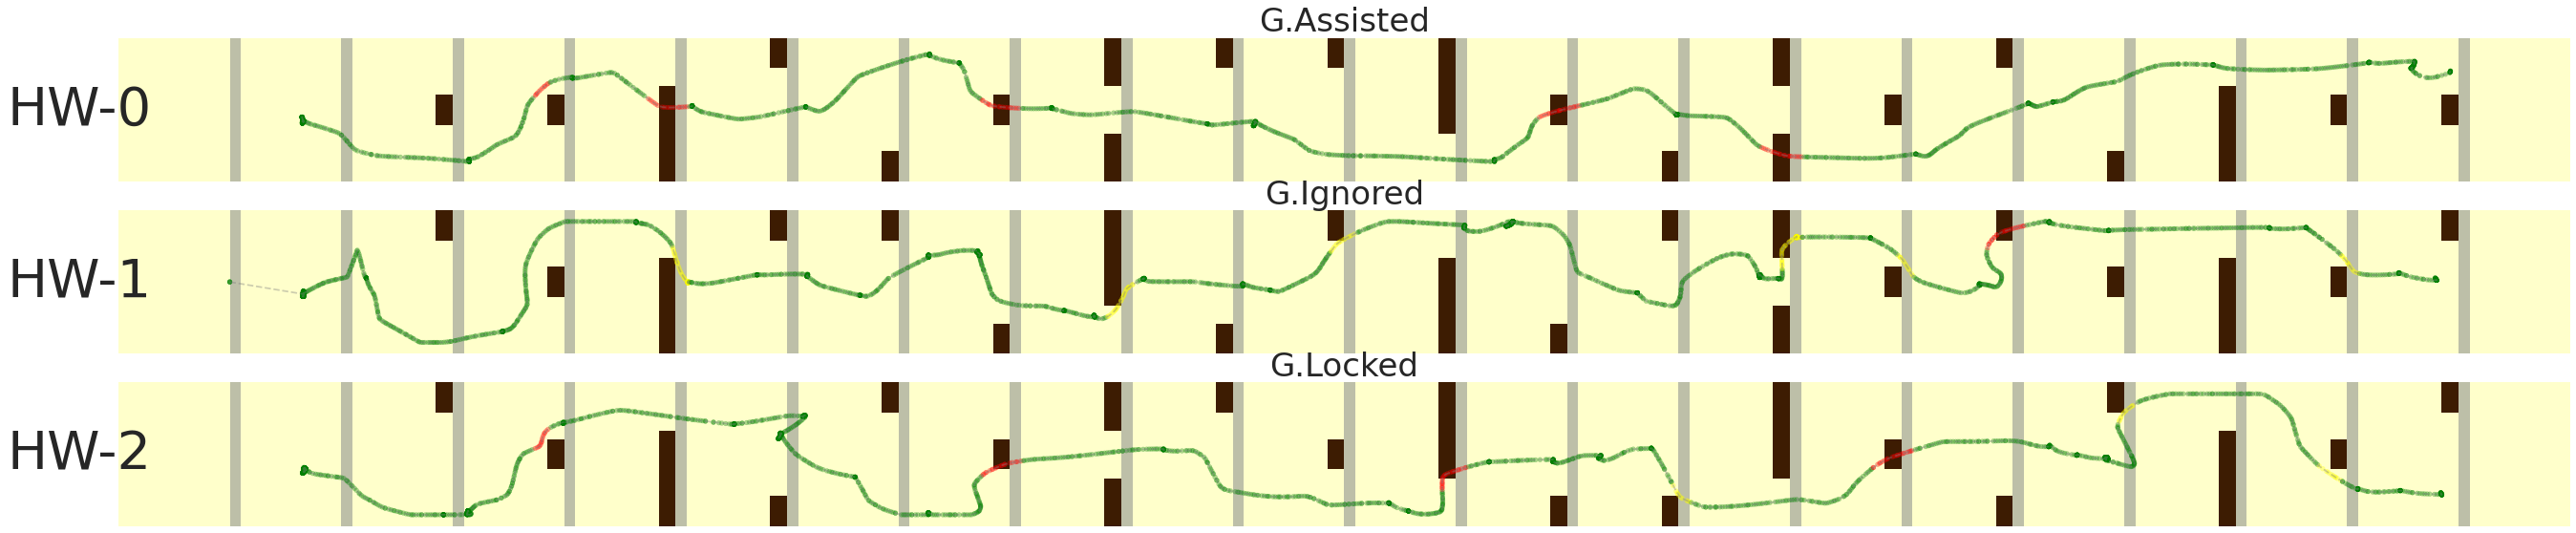

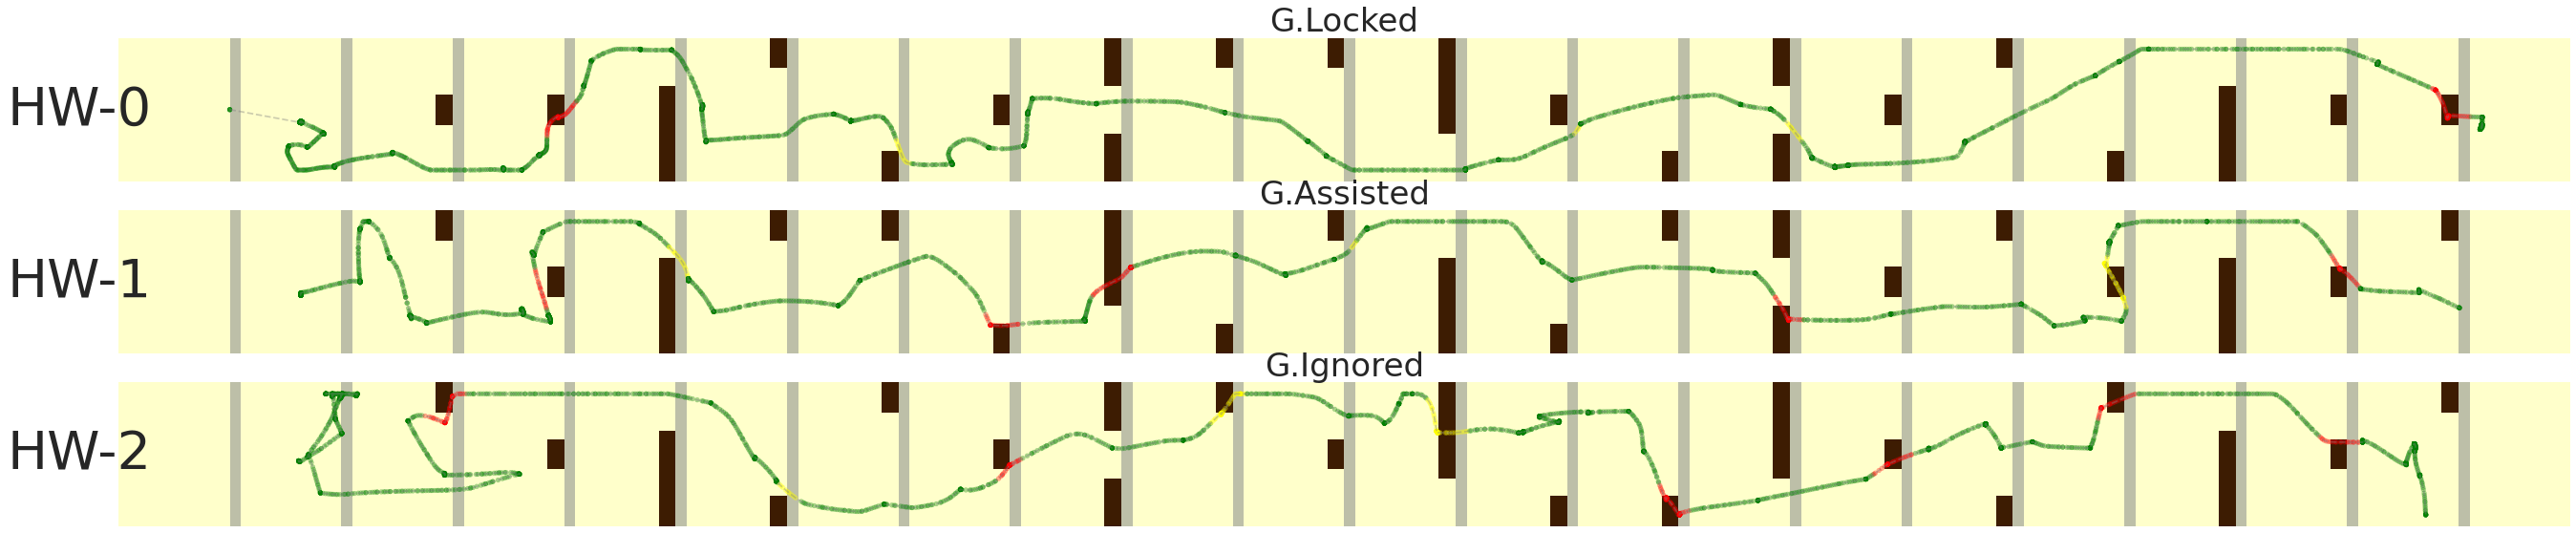

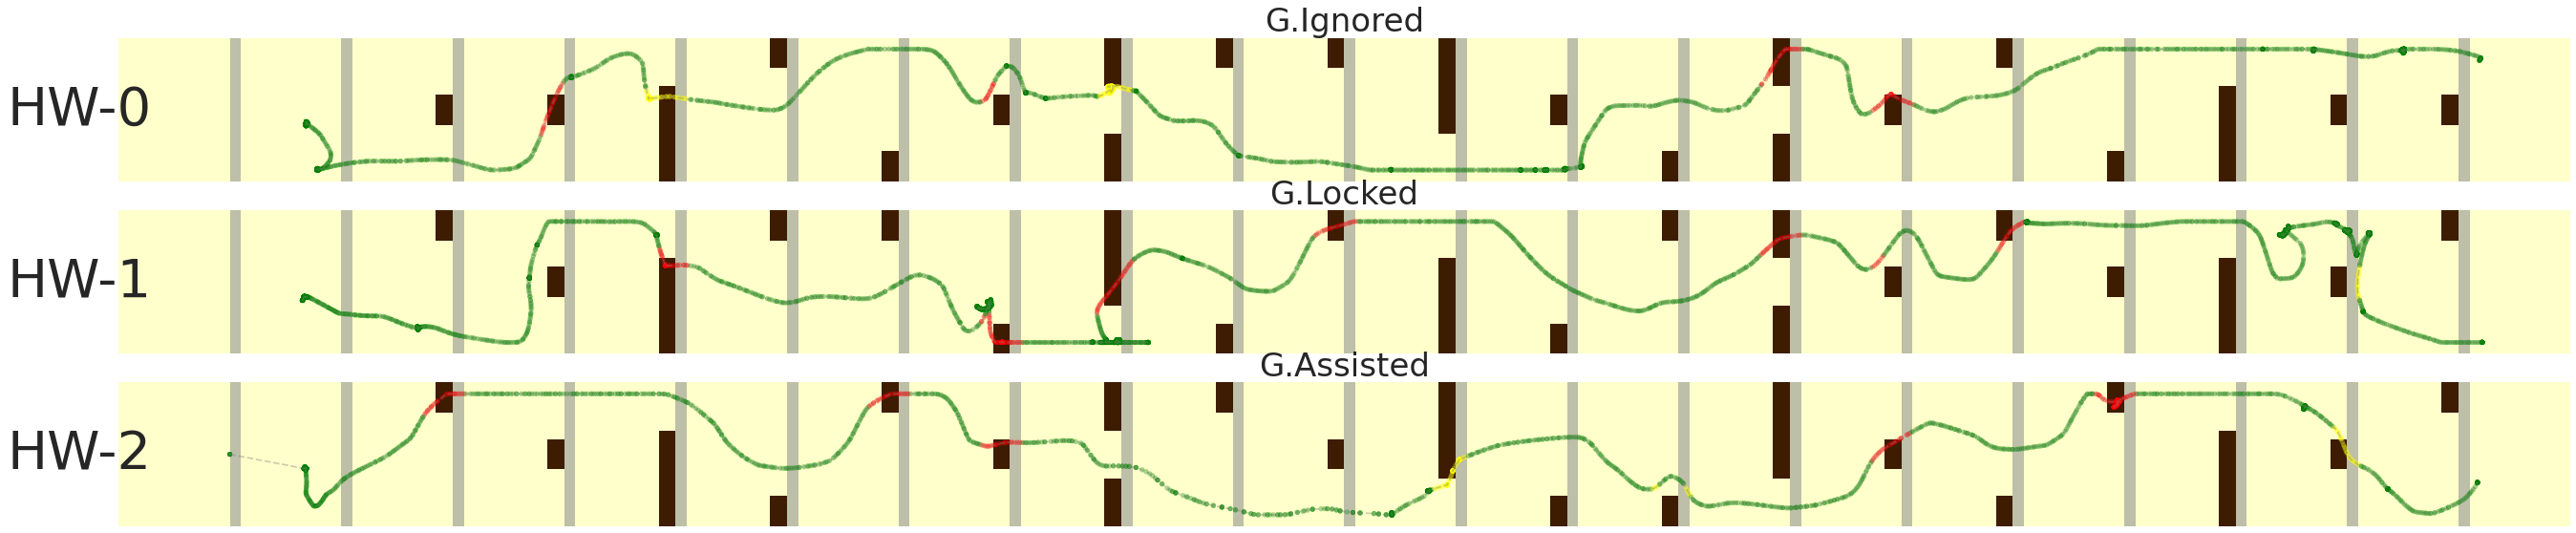

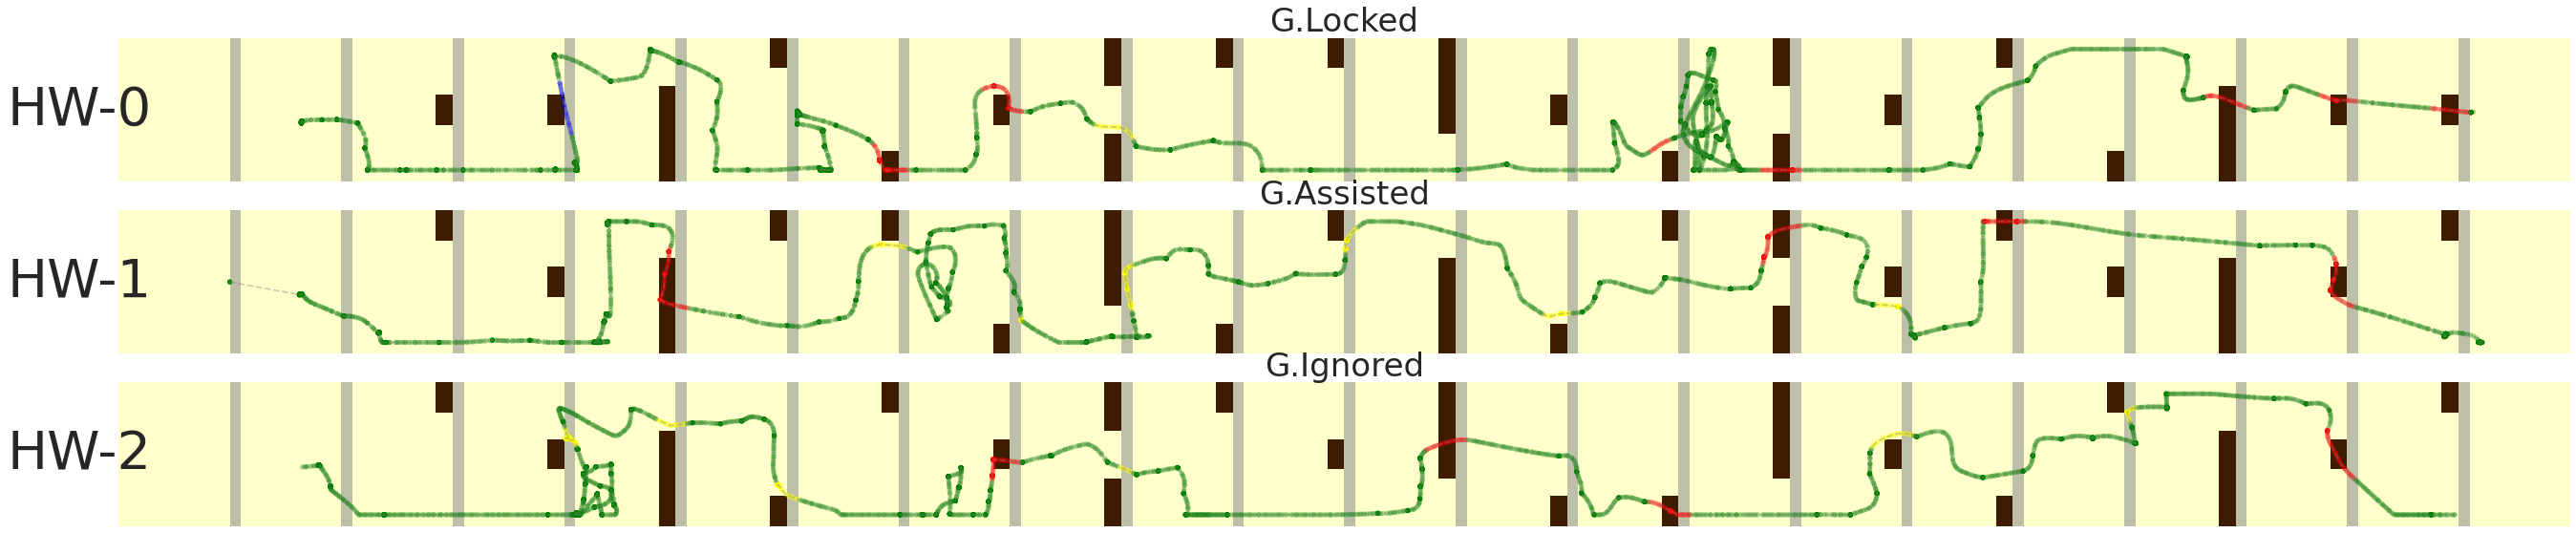

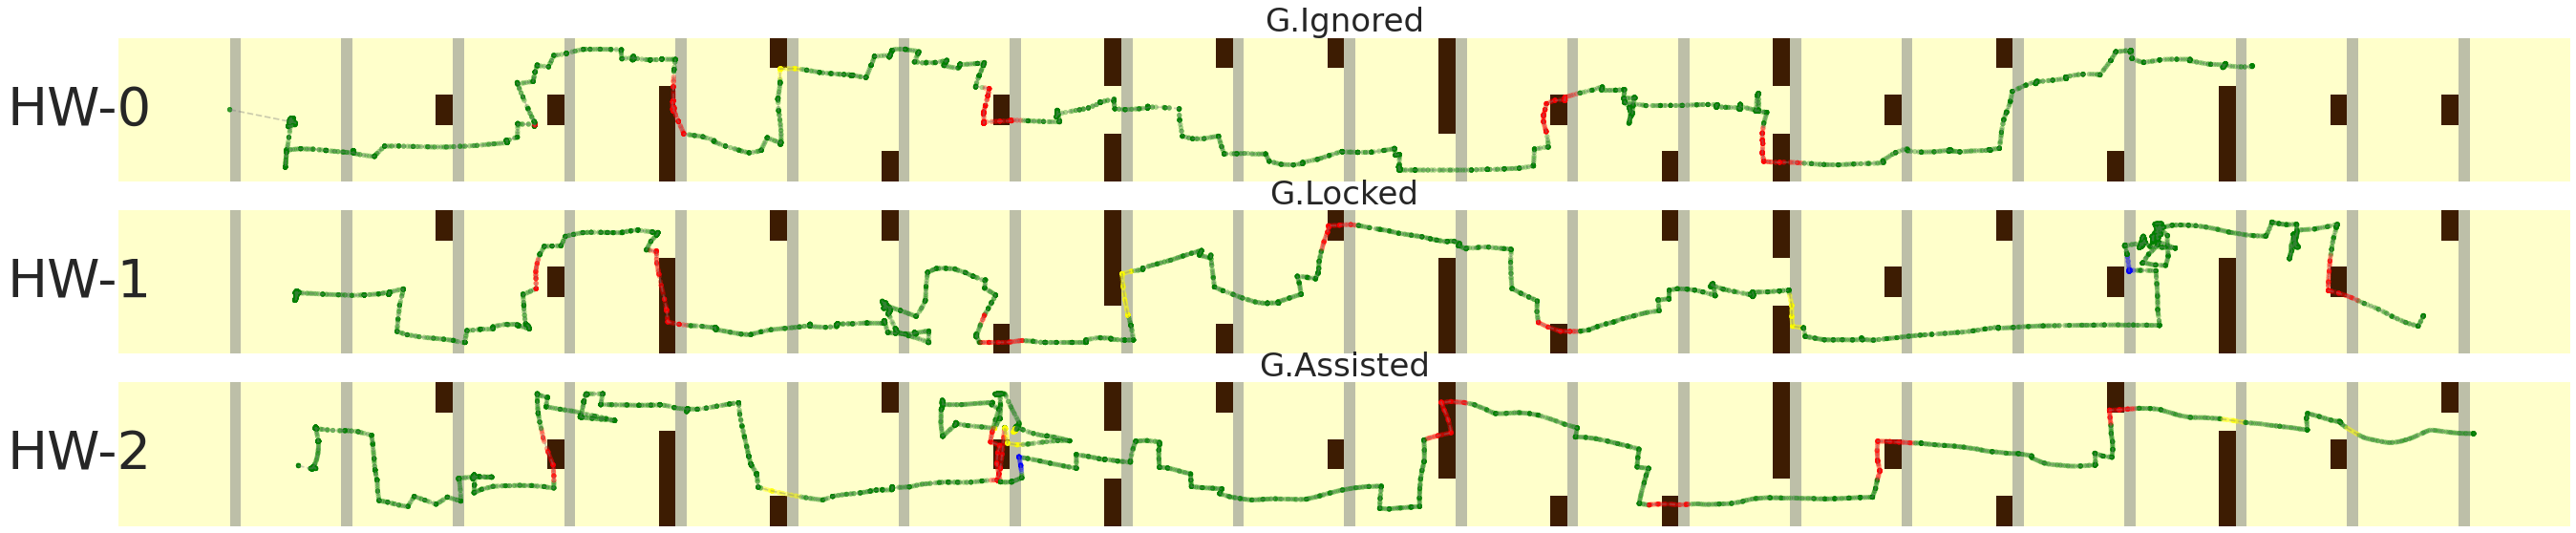

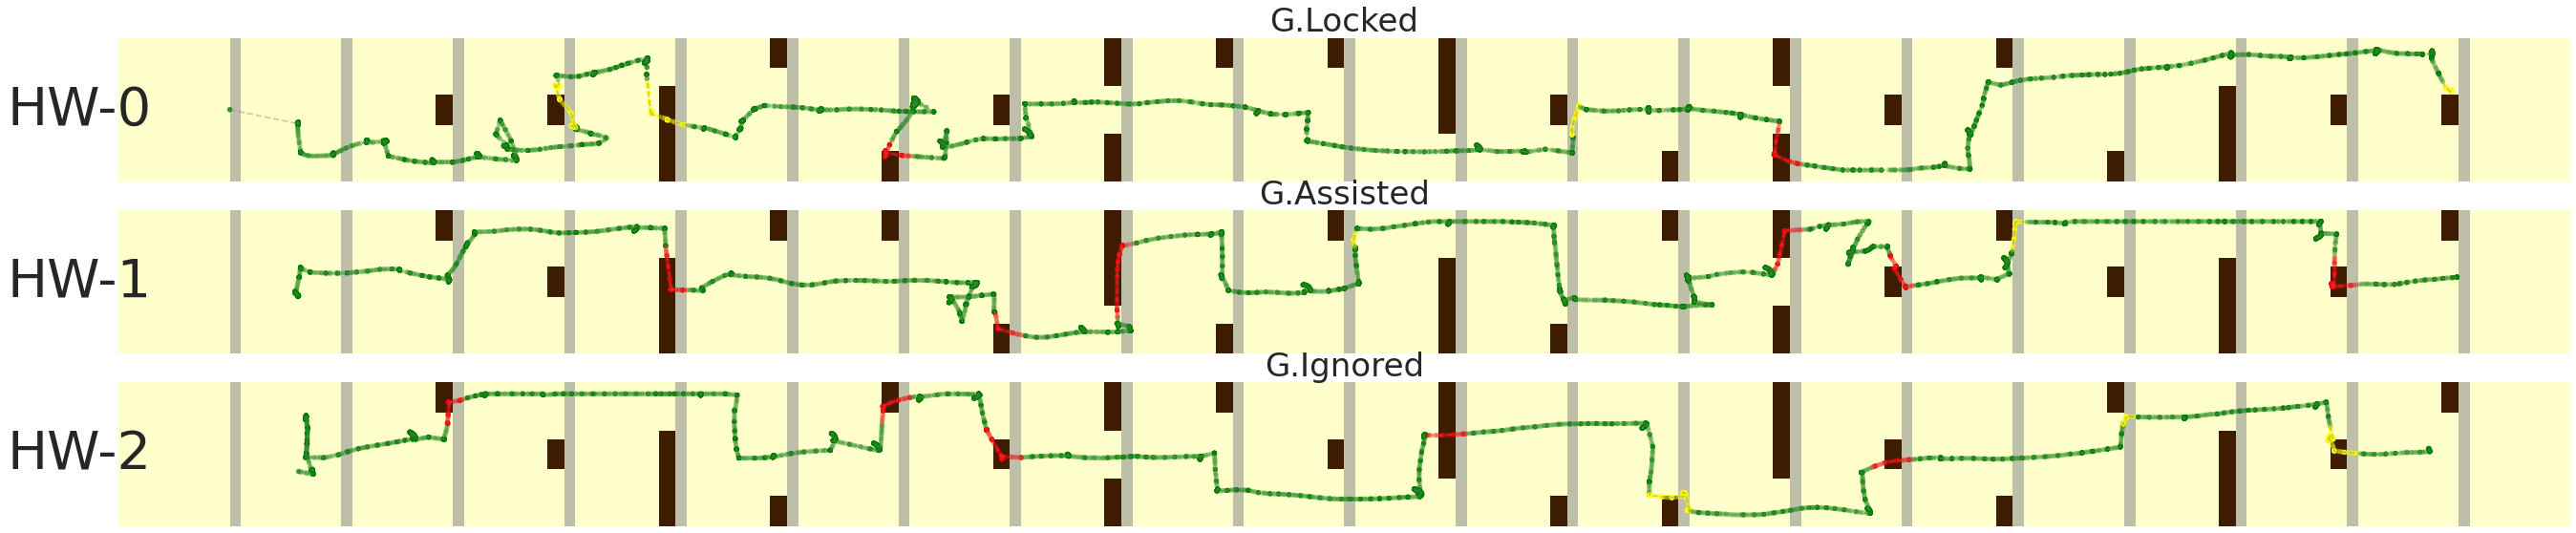

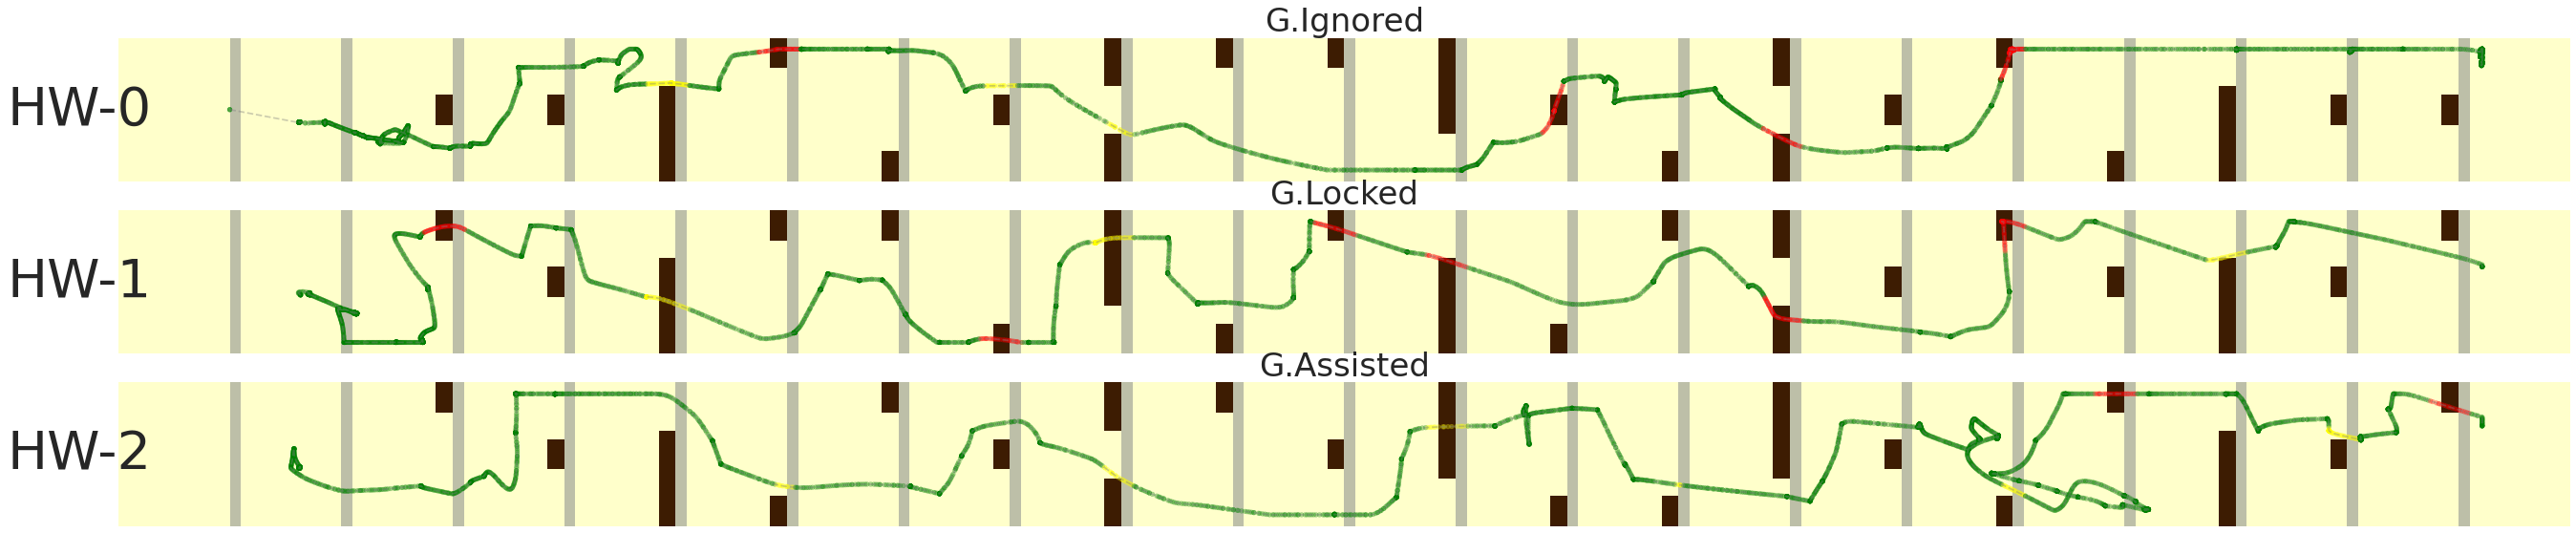

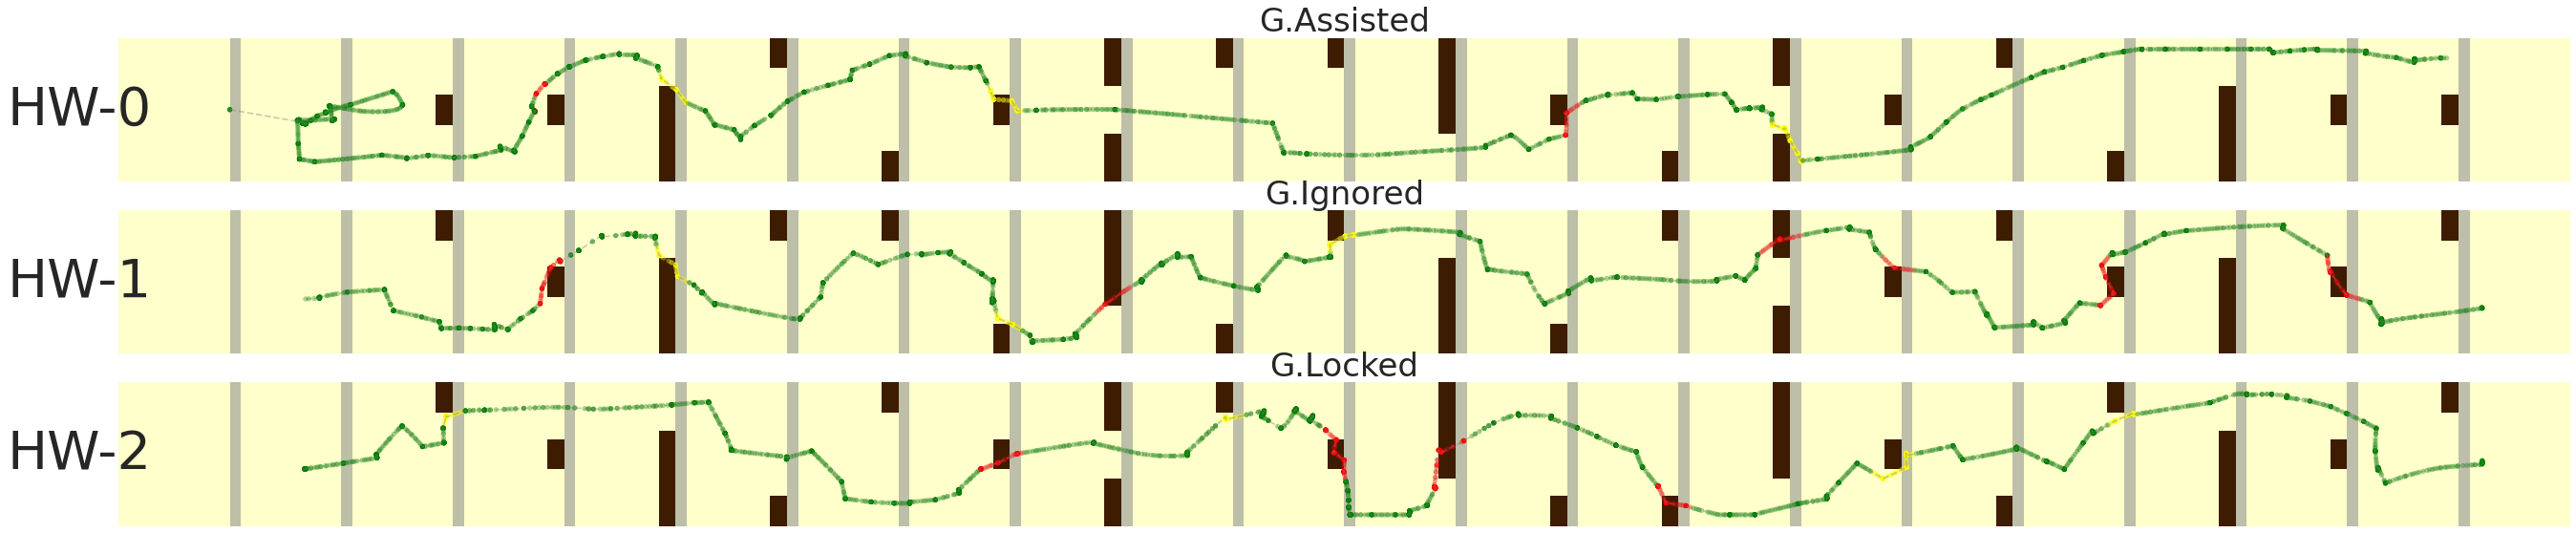

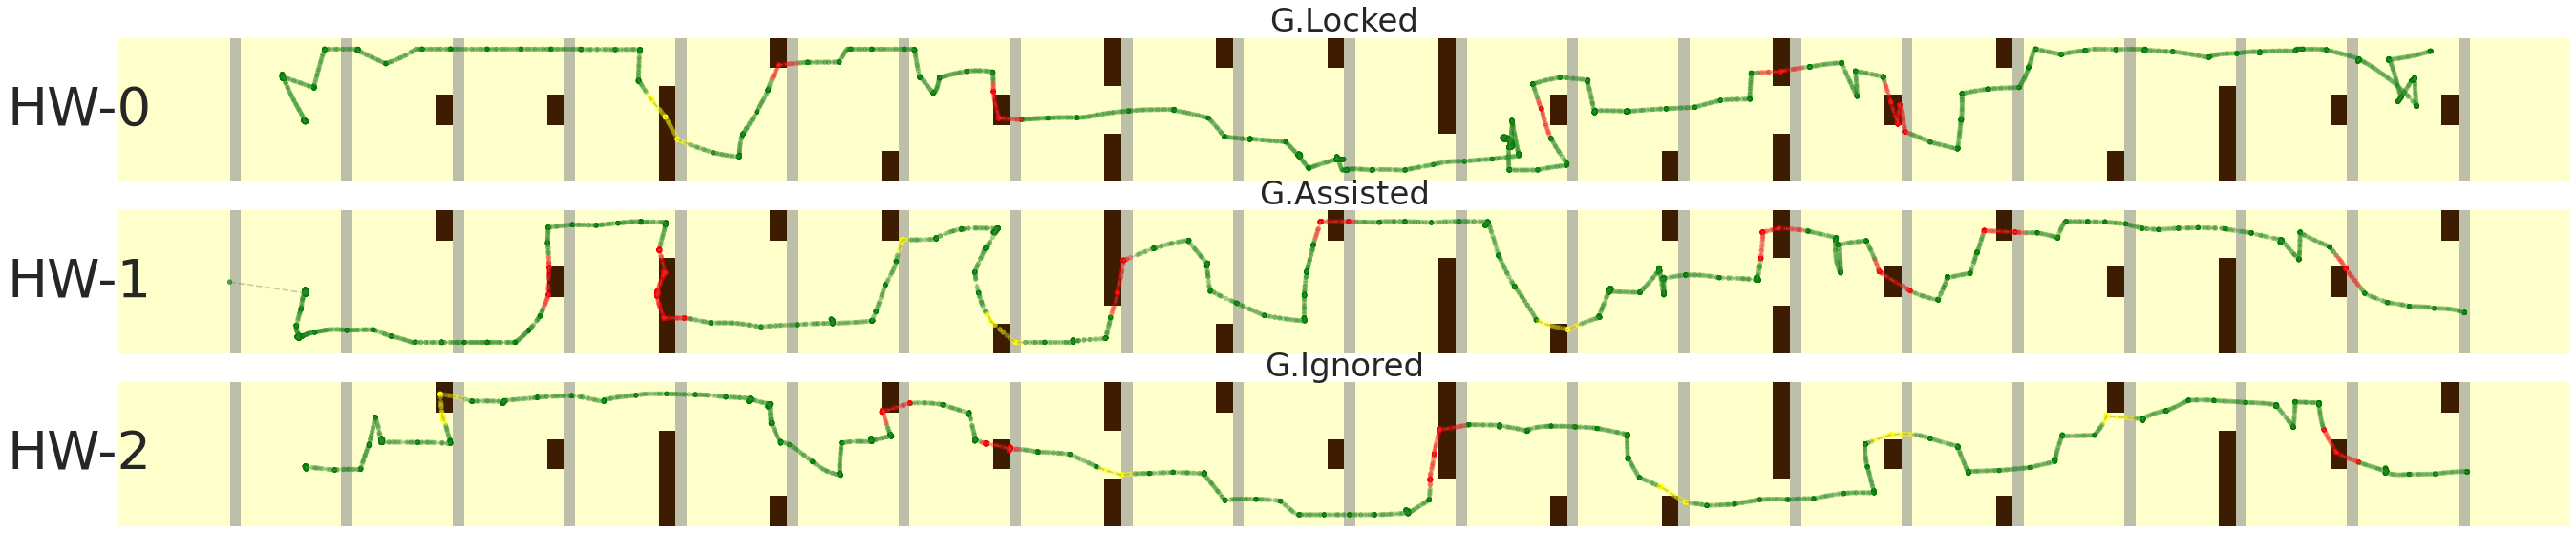

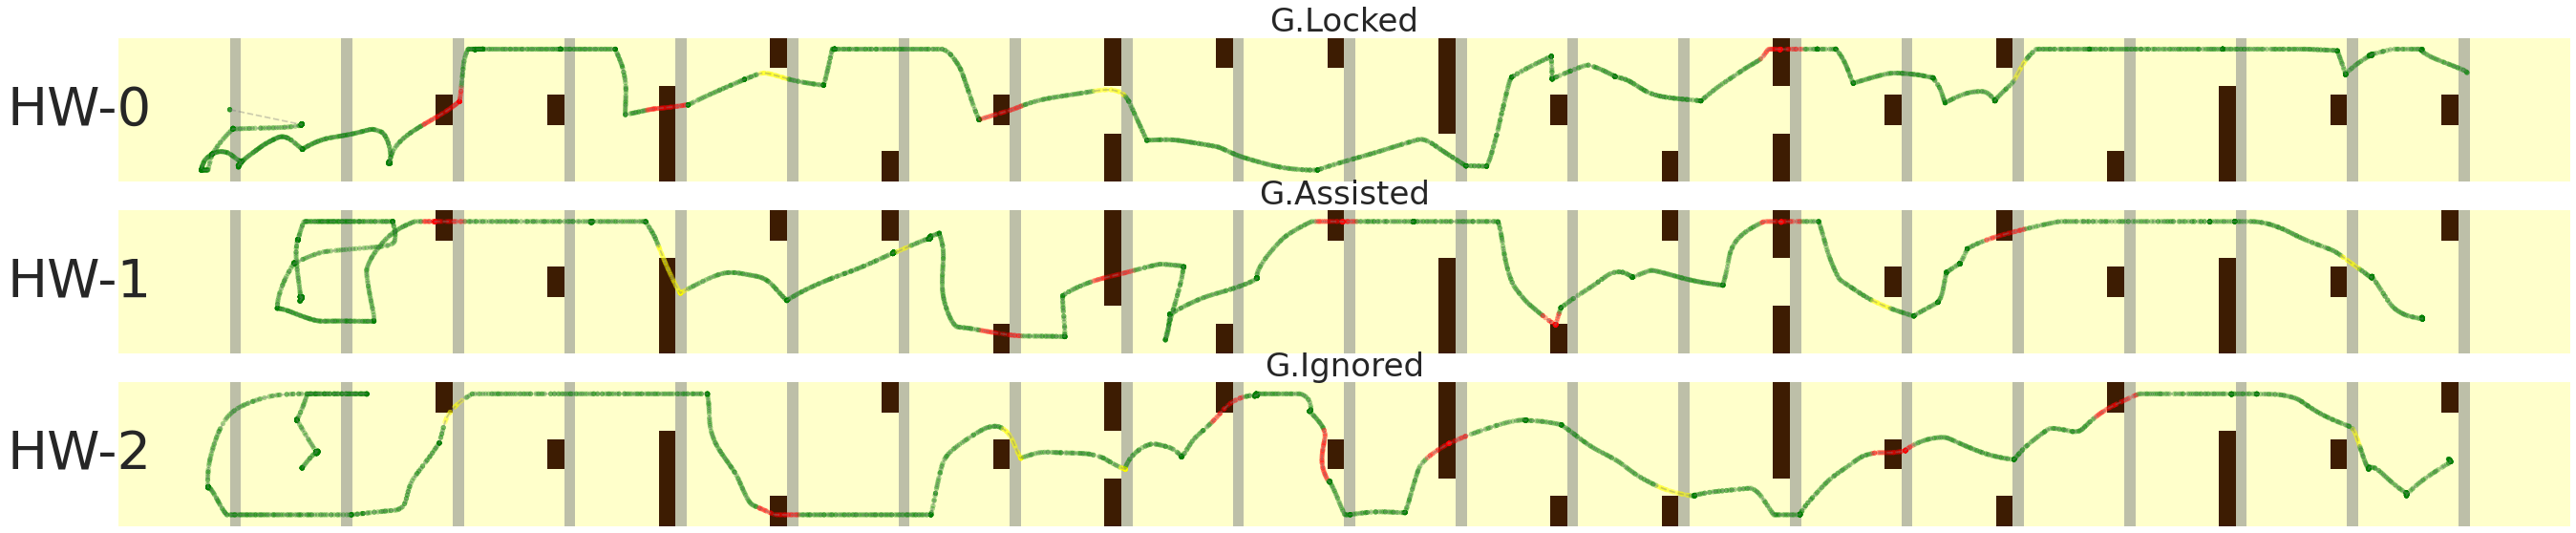

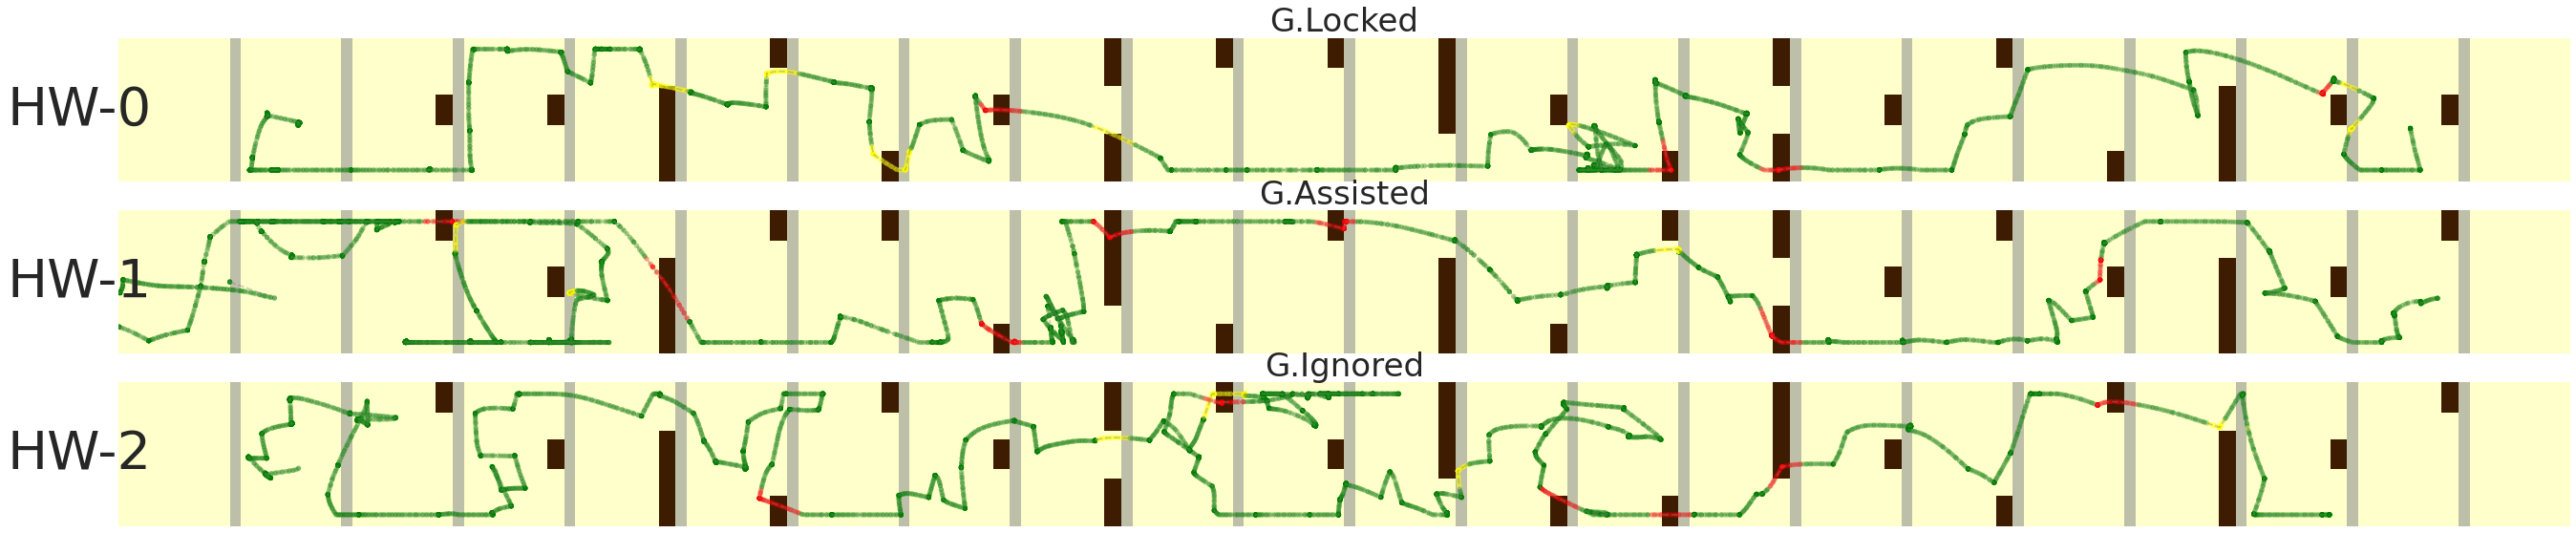

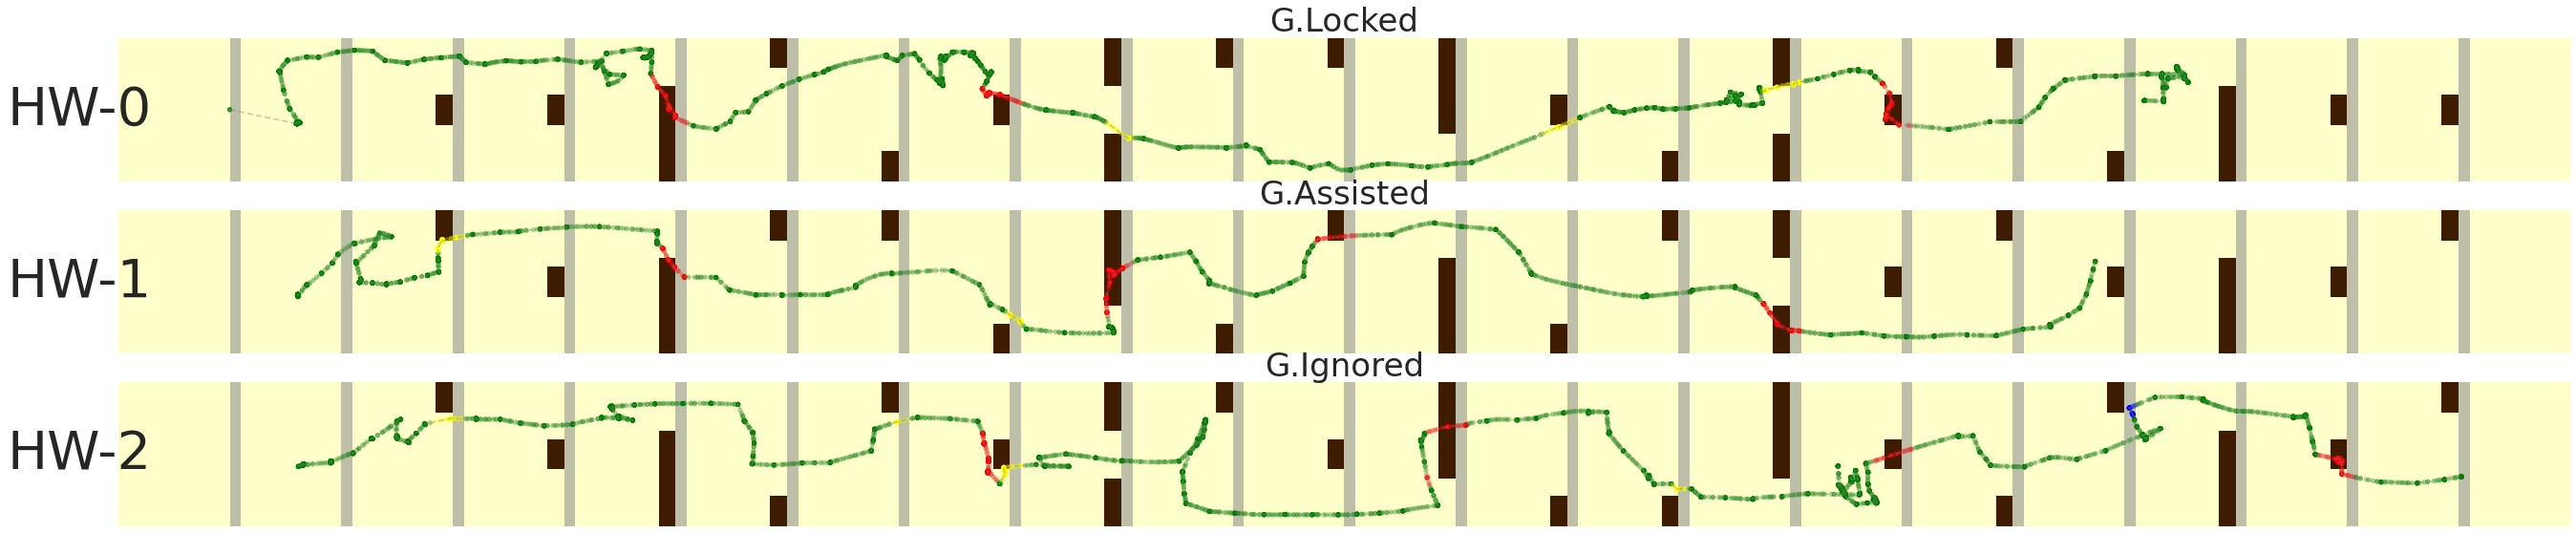

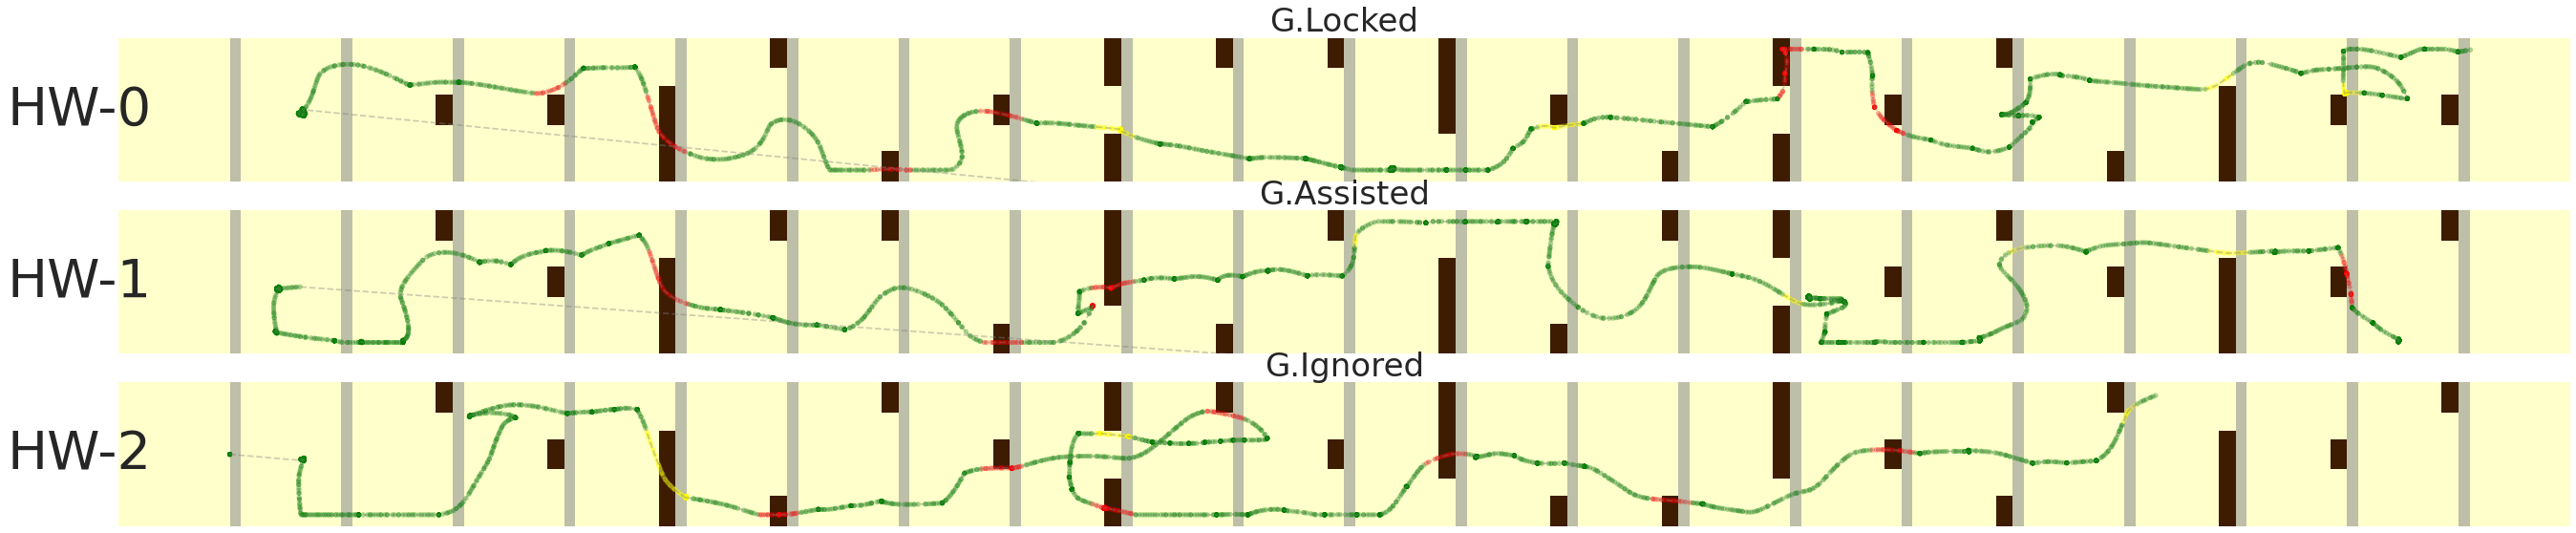

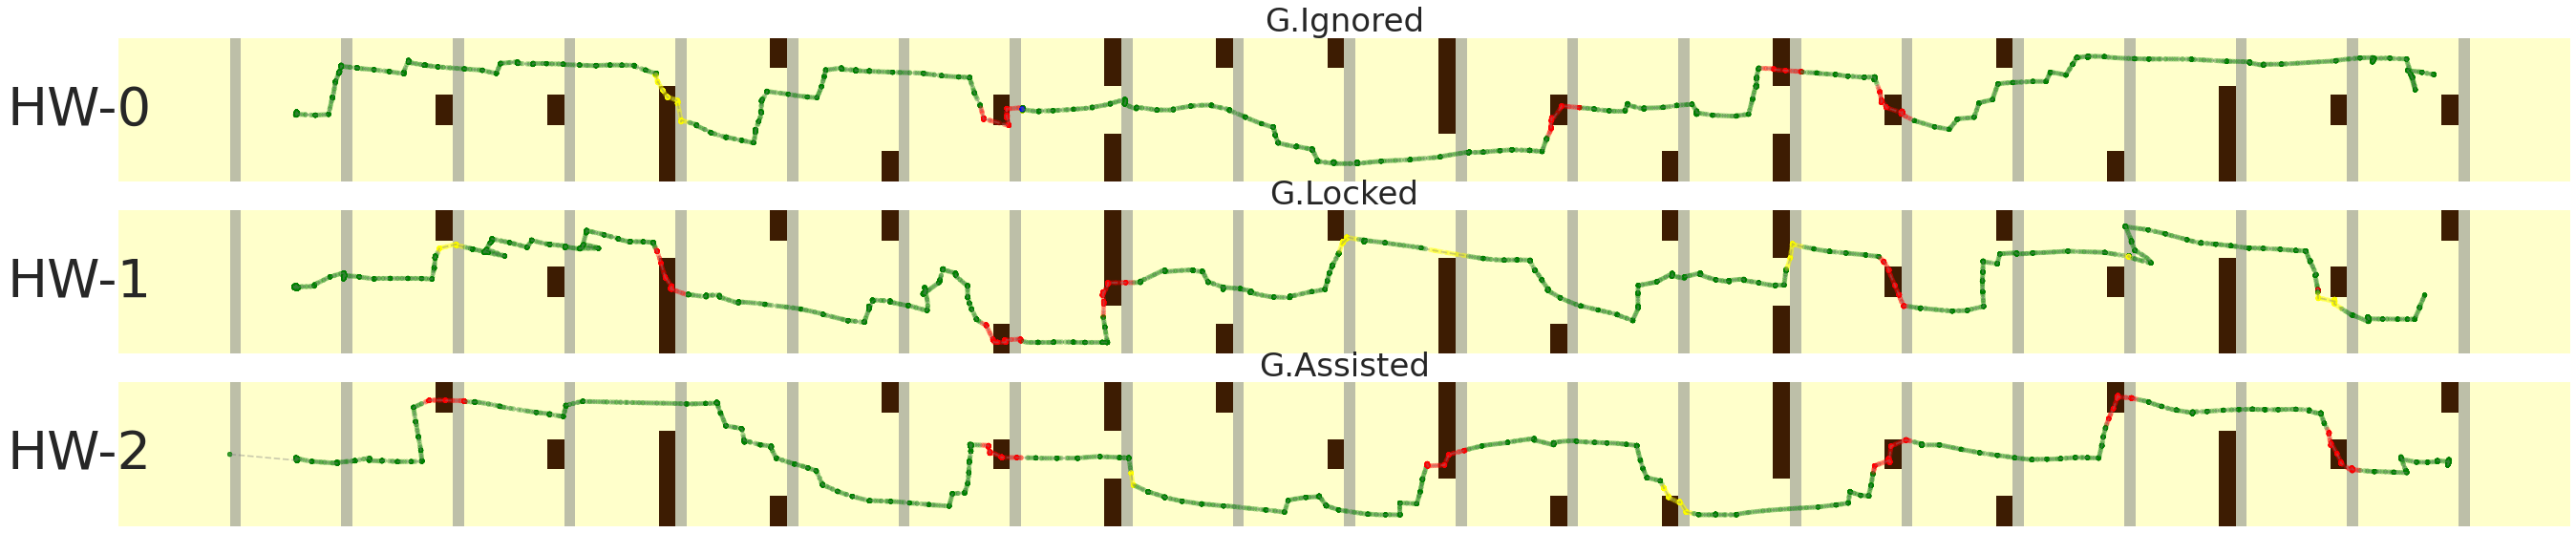

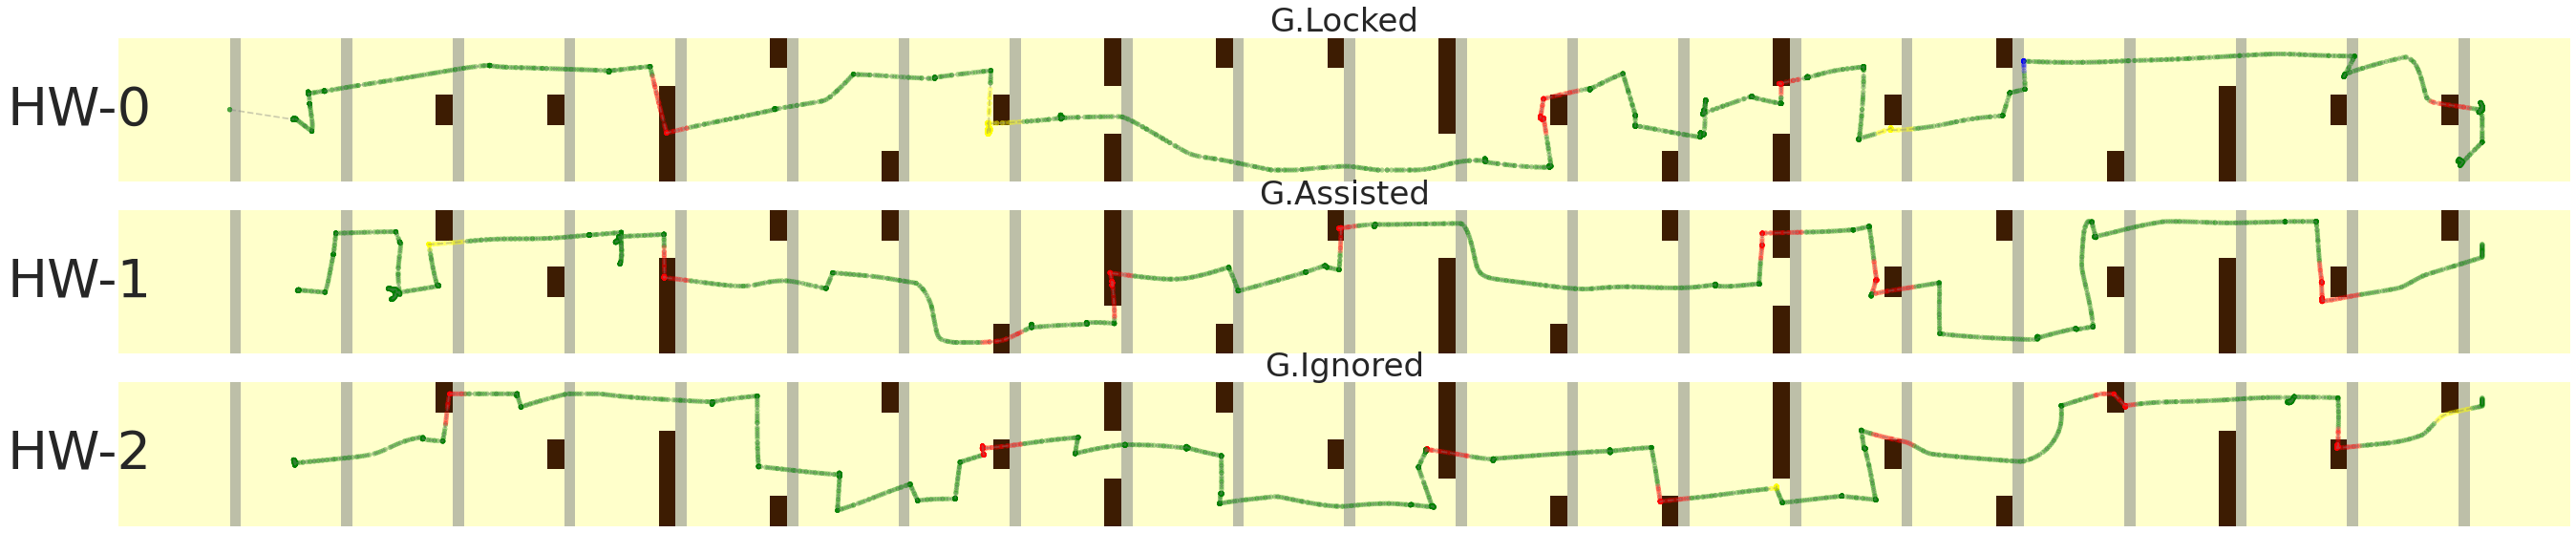

In [29]:
# plot grouped collisions example
df = dfColl.loc[(ID03,slice(None), slice(None), '004')]
# dfColl.groupby(['Block', 'Condition', 'HallwayId', 'Subject']).apply(lambda df: df.loc[df['collision'].shift() != df['collision']])


for subj in subjects:
    fig, axs = map_hallways()

    df = dfColl.loc[(ID03,slice(None), slice(None), subj)]

    for cond in df.index.get_level_values(0).unique():
        data = df.loc[cond]
        hwId = data.index.get_level_values(0).unique()[0]
        data.index = data.index.droplevel(0)

        color = data['GroupedCollision'].replace(to_replace= {
            Collisions.no : "green",
            Collisions.bump : "blue",
            Collisions.strafe: "yellow",
            Collisions.crash : "red"
        }).values
        # color = (data['GroupedCollision'] != data['collision']).replace(to_replace= {
        #     False : "green",
        #     True : "red"
        # }).values

        draw_path(data, axs, hwId, color)

        axs[hwId].set_title(cond, fontsize=34)

In [204]:
seconds_zscores = dfColl[['seconds']].groupby(dfColl.index.names[:-1]).max().groupby("Subject").apply(lambda s: (s - s.mean()) / s.std(ddof=1))

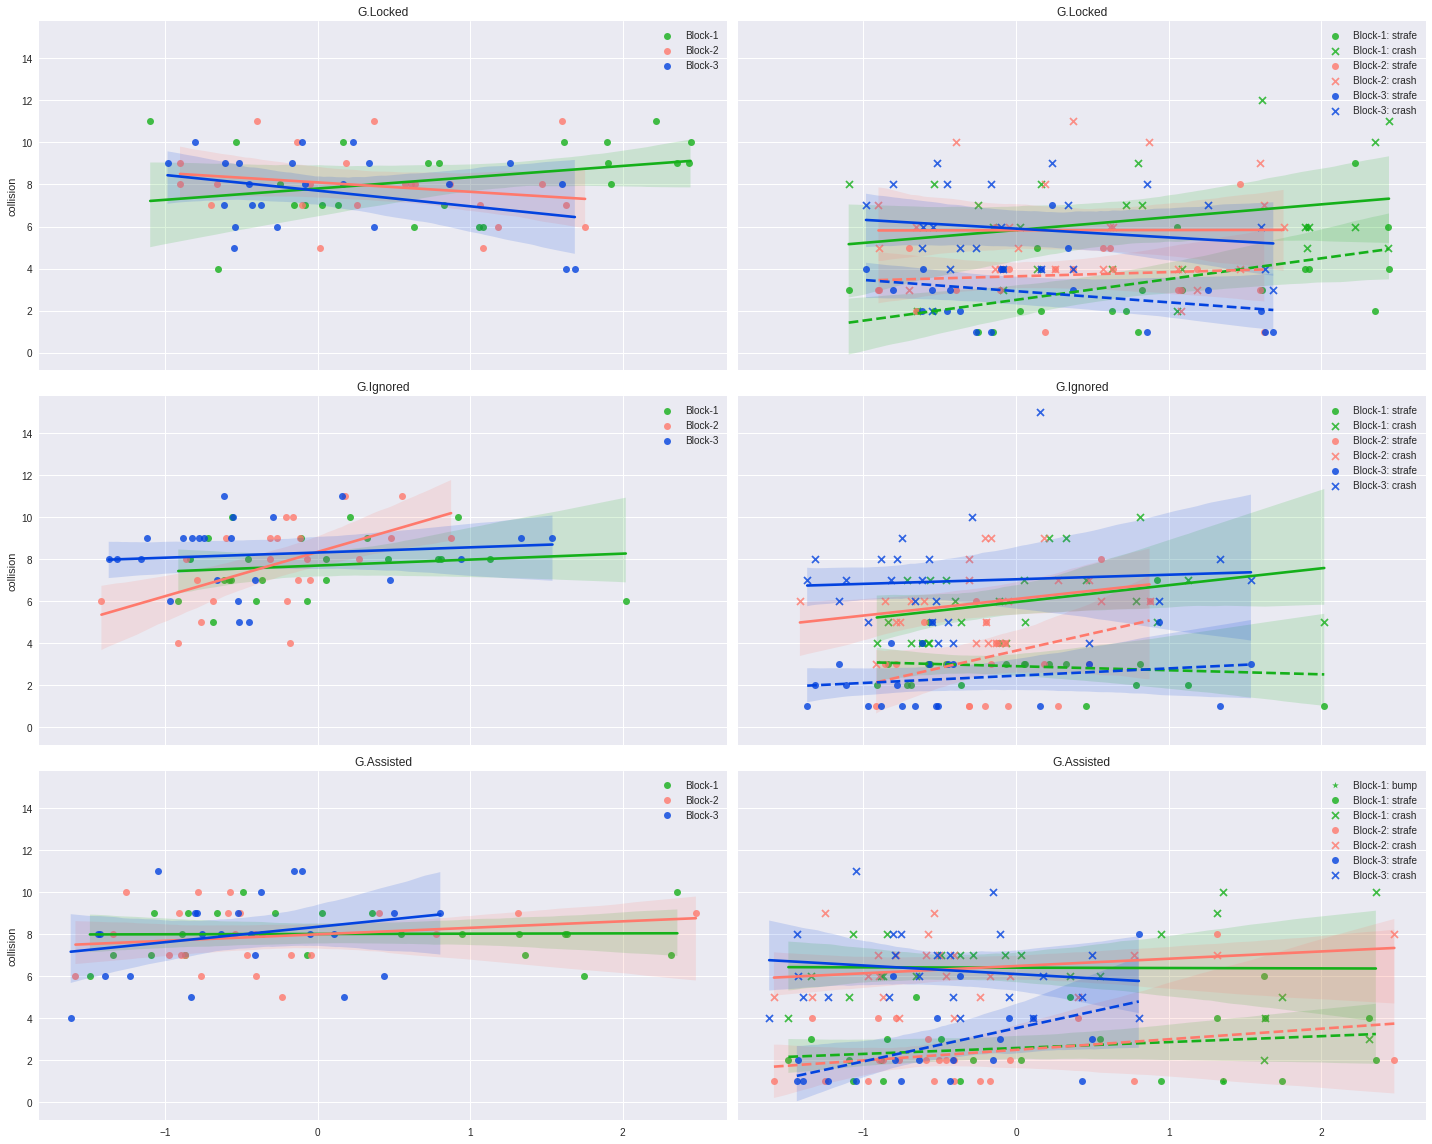

In [218]:
ZSCORE_TIME = True

fig, axs = plt.subplots(3,2,figsize=(20,16), sharex=True, sharey=True)
for bId, block in enumerate([1,2,3]):
    ax = axs[bId]
    blockData = dfColl.loc[block]
    block_color = ["xkcd:salmon", "xkcd:blue", "xkcd:green"][bId-1]
    for cId, con in enumerate(dfColl.index.levels[1].values[::-1]):
        if bId == 0:
            axs[cId, 0].set_title(con)
            axs[cId, 1].set_title(con)
        
        # plot simple collision detection
        ax = axs[cId, 0]
        data = blockData.loc[con]
        coll = data[['collision']] != Collisions.no
        coll['zone'] = data.closestBoxZone
        collisions = coll.groupby(["Subject", "zone"]).max().groupby("Subject").sum()
        if ZSCORE_TIME:
            timetaken = seconds_zscores.loc[block, con, :, :]['seconds']
            timetaken.index = timetaken.index.droplevel(0)
            timetaken.sort_index(inplace=True)
        else:
            timetaken = data['seconds'].groupby('Subject').max()
        sns.regplot(x=timetaken.values, y=collisions, ax=ax, label=f"Block-{block}", color=block_color)
        ax.legend()


        # plot typed collision detection
        ax = axs[cId, 1]
        grouped = data[['GroupedCollision']]
        collCounts = grouped[grouped.shift() != grouped].groupby("Subject").value_counts()
        for crashType in collCounts.index.levels[1].values:
            if crashType == Collisions.no: continue
            marker = 'x' if crashType == Collisions.crash else 'o' if crashType == Collisions.strafe else '*'
            linestyle = '--' if crashType == Collisions.strafe else '-'
            colls = collCounts.loc[:, crashType]
            sns.regplot(x=timetaken.loc[colls.index].values, y=colls.values, ax=ax, label=f"Block-{block}: {str(crashType).split('.')[-1]}",
                            marker=marker, color=block_color, line_kws={"linestyle":linestyle})

        ax.legend()
        
plt.tight_layout()